# 1. Loading the dataset and Importing Libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
import pmdarima
import statsmodels.api as sm

from pmdarima import auto_arima
from itertools import repeat
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import array
from pandas import concat

In [2]:
train = pd.read_csv('..//train_2.csv') # select a subset
key = pd.read_csv('..//key_2.csv')

df = train.copy()
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


## 1.1 Splitting Pages, Site and Access Agent

In [3]:
data = [page.split('_') for page in df.Page]
access = ['_'.join(page[-2:]) for page in data]
site = [page[-3] for page in data]
page = ['_'.join(page[:-3]) for page in data]


df['PageTitle'] = page
df['Site'] = site
df['AccessAgent'] = access

# shift column 'Name' to first position 'PageTitle','Site',
first_column = df.pop('AccessAgent')
df.insert(1,'AccessAgent', first_column)

first_column = df.pop('PageTitle')
df.insert(1,'PageTitle', first_column)

first_column = df.pop('Site')
df.insert(1,'Site', first_column)

df.head()

,Page,Site,PageTitle,AccessAgent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2NE1,all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2PM,all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,3C,all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,4minute,all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,zh.wikipedia.org,52_Hz_I_Love_You,all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


## 1.2 Spliting Access and Agent from AccessAgent

In [4]:
AccessAgent = [AccessAgent.split('_') for AccessAgent in df.AccessAgent]

access = [Acc[0] for Acc in AccessAgent]
agent = [Acc[1] for Acc in AccessAgent]

df['Access'] = access
df['Agent'] = agent

split = [page.split('.') for page in df.Site]
lang  = [language[0] for language in split]

df['lang'] = lang


# shift column 'Name' to first position 'PageTitle','Site',
first_column = df.pop('Access')
df.insert(4,'Access', first_column)

first_column = df.pop('Agent')
df.insert(4,'Agent', first_column)

first_column = df.pop('lang')
df.insert(4,'lang', first_column)

df.head()

,Page,Site,PageTitle,AccessAgent,lang,Agent,Access,2015-07-01,2015-07-02,2015-07-03,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2NE1,all-access_spider,zh,spider,all-access,18.0,11.0,5.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2PM,all-access_spider,zh,spider,all-access,11.0,14.0,15.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,3C,all-access_spider,zh,spider,all-access,1.0,0.0,1.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,4minute,all-access_spider,zh,spider,all-access,35.0,13.0,10.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,zh.wikipedia.org,52_Hz_I_Love_You,all-access_spider,zh,spider,all-access,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


# 2. Exploratory Data Analysis

## 2.1 EDA Based on the Language of the page

In [5]:
lang = list(df['lang'].unique())
access = list(df['Access'].unique())
agent = list(df['Agent'].unique())

In [6]:
print(lang)
print(access)
print(agent)

['zh', 'fr', 'en', 'commons', 'ru', 'www', 'de', 'ja', 'es']
['all-access', 'desktop', 'mobile-web']
['spider', 'all-agents']


These letter words corresponds to different languages:

de-German,
en-English,
es-Spanish,
fr-French,
ja-Japanese,
ru-Russia,
zh-Chinese,
www-World Wide Web,
commons-Remaining Pages

In [7]:
df.fillna(0, inplace=True)
df.head()

,Page,Site,PageTitle,AccessAgent,lang,Agent,Access,2015-07-01,2015-07-02,2015-07-03,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2NE1,all-access_spider,zh,spider,all-access,18.0,11.0,5.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2PM,all-access_spider,zh,spider,all-access,11.0,14.0,15.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,3C,all-access_spider,zh,spider,all-access,1.0,0.0,1.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,4minute,all-access_spider,zh,spider,all-access,35.0,13.0,10.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,zh.wikipedia.org,52_Hz_I_Love_You,all-access_spider,zh,spider,all-access,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [8]:
from tqdm import tnrange as tnrange
from operator import add

lang_views=[]
for i in range(len(lang)):
  lang_views.append(np.zeros(df.shape[1]-7))


for i in tnrange(len(df['lang'])):
    temp=lang.index(df.iloc[i].lang)
    add_list=df.iloc[i].values[7:]
    lang_views[temp]=list(map(add,lang_views[temp],add_list))
    
# Creating a pandas dataframe from the above created list to analyse it more efficiently
lang_views_df=pd.DataFrame(lang_views,index=lang,columns=df.columns.values[7:])
lang_views_df.head(10)

<ipython-input-8-2722e1767a5a>:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(df['lang'])):


  0%|          | 0/145063 [00:00<?, ?it/s]

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
zh,4144988.0,4151189.0,4123659.0,4163448.0,4441286.0,4464290.0,4459421.0,4575842.0,4547843.0,4727889.0,...,4762780.0,5219896.0,5505562.0,5068912.0,5117895.0,4993794.0,5205657.0,5019361.0,5244444.0,5459827.0
fr,8458638.0,8512952.0,8186030.0,8749842.0,8590493.0,8949799.0,8650800.0,8491533.0,8403646.0,7930703.0,...,8902006.0,8494891.0,9044680.0,8173372.0,7982995.0,9222511.0,9067156.0,8004593.0,8444916.0,9111985.0
en,84712190.0,84438545.0,80167728.0,83463204.0,86198637.0,92809436.0,87838054.0,82880196.0,84798911.0,84319456.0,...,78208379.0,83435526.0,98443347.0,99433166.0,93005206.0,92862934.0,97701973.0,74417827.0,71919663.0,75370705.0
commons,1140821.0,1178130.0,1150547.0,951317.0,1058036.0,1210059.0,1261832.0,1397039.0,1211829.0,1160388.0,...,3478284.0,1935325.0,2295477.0,2152909.0,1773990.0,4700532.0,10787037.0,1982500.0,2102161.0,1784866.0
ru,9463854.0,9627643.0,8923463.0,8393214.0,8938528.0,9628896.0,9408180.0,9364117.0,9592309.0,10984872.0,...,9548565.0,9472178.0,9808559.0,9445196.0,11480567.0,14971353.0,10460920.0,9034957.0,9198499.0,10069651.0
www,349713.0,383680.0,325714.0,308756.0,338485.0,391895.0,433312.0,372333.0,331655.0,399316.0,...,1206307.0,899106.0,1295603.0,1221348.0,1295636.0,4123833.0,3500817.0,502495.0,414084.0,428533.0
de,13260519.0,13079896.0,12554042.0,11520379.0,13392347.0,14741758.0,14296292.0,14505194.0,13964778.0,13014478.0,...,13354788.0,11239489.0,12296329.0,12470576.0,12137801.0,12373349.0,14257897.0,11705679.0,10902535.0,12183544.0
ja,11863200.0,13620792.0,12305383.0,15456239.0,14827204.0,12920547.0,12568828.0,12492787.0,12178258.0,12652904.0,...,13059364.0,12608585.0,13146704.0,11785678.0,11350487.0,11695723.0,12963373.0,11691175.0,12497823.0,13938056.0
es,15278553.0,14601013.0,13427632.0,12606538.0,13710356.0,15625554.0,15230654.0,14781870.0,14502906.0,13184481.0,...,14162585.0,11576049.0,14226139.0,17040349.0,18046011.0,17410117.0,16786454.0,14396083.0,11635387.0,13516782.0


### 2.1.1 Total Views per day / Language Plot

In [9]:
# Creating a pandas dataframe from the above created list to analyse it more efficiently
lang_views_df=pd.DataFrame(lang_views,index=lang,columns=df.columns.values[7:])
lang_views_df.head(10)

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
zh,4144988.0,4151189.0,4123659.0,4163448.0,4441286.0,4464290.0,4459421.0,4575842.0,4547843.0,4727889.0,...,4762780.0,5219896.0,5505562.0,5068912.0,5117895.0,4993794.0,5205657.0,5019361.0,5244444.0,5459827.0
fr,8458638.0,8512952.0,8186030.0,8749842.0,8590493.0,8949799.0,8650800.0,8491533.0,8403646.0,7930703.0,...,8902006.0,8494891.0,9044680.0,8173372.0,7982995.0,9222511.0,9067156.0,8004593.0,8444916.0,9111985.0
en,84712190.0,84438545.0,80167728.0,83463204.0,86198637.0,92809436.0,87838054.0,82880196.0,84798911.0,84319456.0,...,78208379.0,83435526.0,98443347.0,99433166.0,93005206.0,92862934.0,97701973.0,74417827.0,71919663.0,75370705.0
commons,1140821.0,1178130.0,1150547.0,951317.0,1058036.0,1210059.0,1261832.0,1397039.0,1211829.0,1160388.0,...,3478284.0,1935325.0,2295477.0,2152909.0,1773990.0,4700532.0,10787037.0,1982500.0,2102161.0,1784866.0
ru,9463854.0,9627643.0,8923463.0,8393214.0,8938528.0,9628896.0,9408180.0,9364117.0,9592309.0,10984872.0,...,9548565.0,9472178.0,9808559.0,9445196.0,11480567.0,14971353.0,10460920.0,9034957.0,9198499.0,10069651.0
www,349713.0,383680.0,325714.0,308756.0,338485.0,391895.0,433312.0,372333.0,331655.0,399316.0,...,1206307.0,899106.0,1295603.0,1221348.0,1295636.0,4123833.0,3500817.0,502495.0,414084.0,428533.0
de,13260519.0,13079896.0,12554042.0,11520379.0,13392347.0,14741758.0,14296292.0,14505194.0,13964778.0,13014478.0,...,13354788.0,11239489.0,12296329.0,12470576.0,12137801.0,12373349.0,14257897.0,11705679.0,10902535.0,12183544.0
ja,11863200.0,13620792.0,12305383.0,15456239.0,14827204.0,12920547.0,12568828.0,12492787.0,12178258.0,12652904.0,...,13059364.0,12608585.0,13146704.0,11785678.0,11350487.0,11695723.0,12963373.0,11691175.0,12497823.0,13938056.0
es,15278553.0,14601013.0,13427632.0,12606538.0,13710356.0,15625554.0,15230654.0,14781870.0,14502906.0,13184481.0,...,14162585.0,11576049.0,14226139.0,17040349.0,18046011.0,17410117.0,16786454.0,14396083.0,11635387.0,13516782.0


Next we will calculate no of active days, say if a page was started 2016-09-01 

then before that it will be having values null which we dont have to consider while finding avg.

In [10]:
df2 = train.copy()
data = [page.split('_') for page in df.Page]
site = [word[-3] for word in data]
lst = [word.split('.') for word in site]

language = [word[0] for word in lst]
df2['lang'] = language

first_column = df2.pop('lang')
df2.insert(1,'lang', first_column)
df2

,Page,lang,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,zh,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,zh,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,zh,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,zh,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,zh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,es,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4.0,3.0,6.0,5.0,2.0,4.0,4.0,8.0,2.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,es,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,7.0,5.0,0.0,5.0,5.0,2.0,2.0,4.0
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,es,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,25.0,22.0,47.0,42.0,13.0,9.0,21.0,16.0,6.0
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,es,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,6.0,5.0,1.0,5.0,8.0,2.0,4.0,3.0,3.0


In [17]:
days_count = []

for i in range(len(lang)):
    days_count.append(np.zeros(df.shape[1]-7))

for i in tnrange(len(df['lang'])):
    temp=lang.index(df.iloc[i].lang)
    row = train.iloc[i].copy()
    row.loc[~row.isnull()] = 1
    row.loc[row.isnull()] = 0
    add_list = row.values[1:]
    days_count[temp]=list(map(add,days_count[temp],add_list))
    

<ipython-input-17-e837ef6cb81a>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(df['lang'])):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [19]:
# Creating a pandas dataframe from the above created list to analyse it more efficiently
active_pages_data=pd.DataFrame(days_count,index=lang,columns=df.columns.values[7:])
active_pages_data.head(10)

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
zh,13538.0,13558.0,13533.0,13557.0,13608.0,13582.0,13593.0,13610.0,13629.0,13624.0,...,17150.0,17163.0,17149.0,17150.0,17155.0,17196.0,17200.0,17174.0,17166.0,17156.0
fr,16062.0,16061.0,16069.0,16074.0,16084.0,16092.0,16083.0,16088.0,16099.0,16097.0,...,17771.0,17750.0,17765.0,17747.0,17750.0,17743.0,17751.0,17780.0,17764.0,17753.0
en,20560.0,20610.0,20751.0,20760.0,20732.0,20796.0,20606.0,20768.0,20841.0,20853.0,...,23794.0,23766.0,23772.0,23833.0,23792.0,23600.0,23694.0,24065.0,24049.0,21820.0
commons,7293.0,7254.0,7368.0,7290.0,7227.0,7305.0,7343.0,7492.0,7453.0,7363.0,...,8779.0,8689.0,8687.0,9226.0,9808.0,10277.0,8804.0,10146.0,8734.0,8828.0
ru,13627.0,13624.0,13643.0,13628.0,13641.0,13661.0,13662.0,13683.0,13673.0,13654.0,...,14978.0,14947.0,14949.0,14954.0,14957.0,14943.0,14947.0,14988.0,14959.0,14948.0
www,5111.0,5025.0,5024.0,4999.0,4991.0,4989.0,4971.0,4988.0,4938.0,4948.0,...,6578.0,6526.0,6545.0,6511.0,6491.0,7044.0,6677.0,7075.0,6520.0,6551.0
de,16546.0,16547.0,16547.0,16526.0,16536.0,16562.0,16561.0,16551.0,16582.0,16576.0,...,18457.0,18505.0,18430.0,18431.0,18432.0,18463.0,18485.0,18512.0,18505.0,18431.0
ja,18605.0,18600.0,18611.0,18611.0,18606.0,18616.0,18613.0,18613.0,18625.0,18624.0,...,20013.0,20002.0,20011.0,19995.0,19996.0,19995.0,20002.0,20222.0,20000.0,19985.0
es,12981.0,12968.0,12973.0,12964.0,12979.0,12977.0,12967.0,12976.0,12979.0,12982.0,...,14023.0,14039.0,14038.0,14021.0,14025.0,14027.0,14036.0,14040.0,14034.0,14013.0


### 2.1.2 No of Active Pages Per Day/ Language Plot

In [20]:
# Creating a pandas dataframe from the above created list to analyse it more efficiently
active_pages_data=pd.DataFrame(days_count,index=lang,columns=df.columns.values[7:])
active_pages_data.head(10)

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
zh,13538.0,13558.0,13533.0,13557.0,13608.0,13582.0,13593.0,13610.0,13629.0,13624.0,...,17150.0,17163.0,17149.0,17150.0,17155.0,17196.0,17200.0,17174.0,17166.0,17156.0
fr,16062.0,16061.0,16069.0,16074.0,16084.0,16092.0,16083.0,16088.0,16099.0,16097.0,...,17771.0,17750.0,17765.0,17747.0,17750.0,17743.0,17751.0,17780.0,17764.0,17753.0
en,20560.0,20610.0,20751.0,20760.0,20732.0,20796.0,20606.0,20768.0,20841.0,20853.0,...,23794.0,23766.0,23772.0,23833.0,23792.0,23600.0,23694.0,24065.0,24049.0,21820.0
commons,7293.0,7254.0,7368.0,7290.0,7227.0,7305.0,7343.0,7492.0,7453.0,7363.0,...,8779.0,8689.0,8687.0,9226.0,9808.0,10277.0,8804.0,10146.0,8734.0,8828.0
ru,13627.0,13624.0,13643.0,13628.0,13641.0,13661.0,13662.0,13683.0,13673.0,13654.0,...,14978.0,14947.0,14949.0,14954.0,14957.0,14943.0,14947.0,14988.0,14959.0,14948.0
www,5111.0,5025.0,5024.0,4999.0,4991.0,4989.0,4971.0,4988.0,4938.0,4948.0,...,6578.0,6526.0,6545.0,6511.0,6491.0,7044.0,6677.0,7075.0,6520.0,6551.0
de,16546.0,16547.0,16547.0,16526.0,16536.0,16562.0,16561.0,16551.0,16582.0,16576.0,...,18457.0,18505.0,18430.0,18431.0,18432.0,18463.0,18485.0,18512.0,18505.0,18431.0
ja,18605.0,18600.0,18611.0,18611.0,18606.0,18616.0,18613.0,18613.0,18625.0,18624.0,...,20013.0,20002.0,20011.0,19995.0,19996.0,19995.0,20002.0,20222.0,20000.0,19985.0
es,12981.0,12968.0,12973.0,12964.0,12979.0,12977.0,12967.0,12976.0,12979.0,12982.0,...,14023.0,14039.0,14038.0,14021.0,14025.0,14027.0,14036.0,14040.0,14034.0,14013.0


### 2.1.3 Avg Views Per Day/ Language

In [21]:
avg_views_per_language = pd.DataFrame(pd.DataFrame(lang_views_df)/pd.DataFrame(active_pages_data).values)
avg_views_per_language

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
zh,306.174324,306.180041,304.711372,307.106882,326.373163,328.691651,328.067461,336.211756,333.688679,347.026497,...,277.713120,304.136573,321.042743,295.563382,298.332556,290.404396,302.654477,292.265110,305.513457,318.245920
fr,526.624206,530.038727,509.429958,544.347518,534.101778,556.164492,537.884723,527.817815,521.998012,492.682053,...,500.928817,478.585408,509.129187,460.549501,449.746197,519.783069,510.796913,450.202081,475.394956,513.264519
en,4120.242704,4096.969675,3863.318780,4020.385549,4157.757910,4462.850356,4262.741629,3990.764445,4068.850391,4043.516808,...,3286.894974,3510.709669,4141.147022,4172.079302,3909.095746,3934.870085,4123.490040,3092.367629,2990.546925,3454.202796
commons,156.426848,162.411084,156.154587,130.496159,146.400443,165.648049,171.841482,186.470769,162.596136,157.597175,...,396.205035,222.732766,264.242777,233.352374,180.871737,457.383672,1225.242731,195.397201,240.687085,202.182374
ru,694.492845,706.667866,654.068973,615.880100,655.269262,704.845619,688.638560,684.361397,701.551159,804.516772,...,637.506009,633.717669,656.134792,631.616691,767.571505,1001.897410,699.867532,602.812717,614.914032,673.645371
www,68.423596,76.354229,64.831608,61.763553,67.819074,78.551814,87.167974,74.645750,67.163832,80.702506,...,183.385071,137.772908,197.953094,187.582245,199.604992,585.439097,524.309870,71.024028,63.509816,65.414898
de,801.433519,790.469330,758.689914,697.106317,809.890360,890.095278,863.250528,876.393813,842.164878,785.139841,...,723.562226,607.375790,667.190939,676.608757,658.517849,670.170016,771.322532,632.329246,589.166982,661.035429
ja,637.635044,732.300645,661.188706,830.489442,796.904439,694.056027,675.271477,671.186106,653.866201,679.387027,...,652.544046,630.366213,656.973864,589.431258,567.637878,584.932383,648.103840,578.141381,624.891150,697.425869
es,1176.993529,1125.926357,1035.044477,972.426566,1056.349179,1204.096016,1174.570371,1139.170006,1117.413206,1015.597057,...,1009.954004,824.563644,1013.402123,1215.344769,1286.703102,1241.186070,1195.957110,1025.362037,829.085578,964.588739


### 2.1.4 Plotting Avg Traffic of Per day/ Language

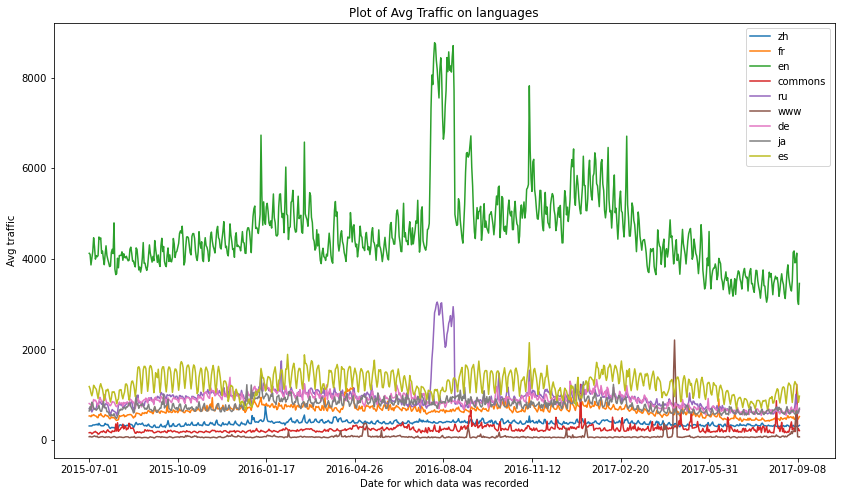

In [22]:
# Plotting the traffic of each language on a single plot to understand their scale
avg_views_per_language.transpose().plot(figsize=(14,8),title='Plot of Avg Traffic on languages')
plt.xlabel('Date for which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

It is very interesting to observe that both english and russian follows almost same pattern, only difference is in the values.

English language has a quite high avg traffic as compare to rest of the languages.

Spanish language also has good avg traffic.

Conclusion : English language has the highest avg traffic, most probably because it is most spoken language of the world, it is followed by spanish,russian,german and japanese

### 2.1.5 Plots to observe each language individually

### 2.1.5.1 Avg Views / Month days

#### Line graph for Avg Traffic / Month Day (Russian)

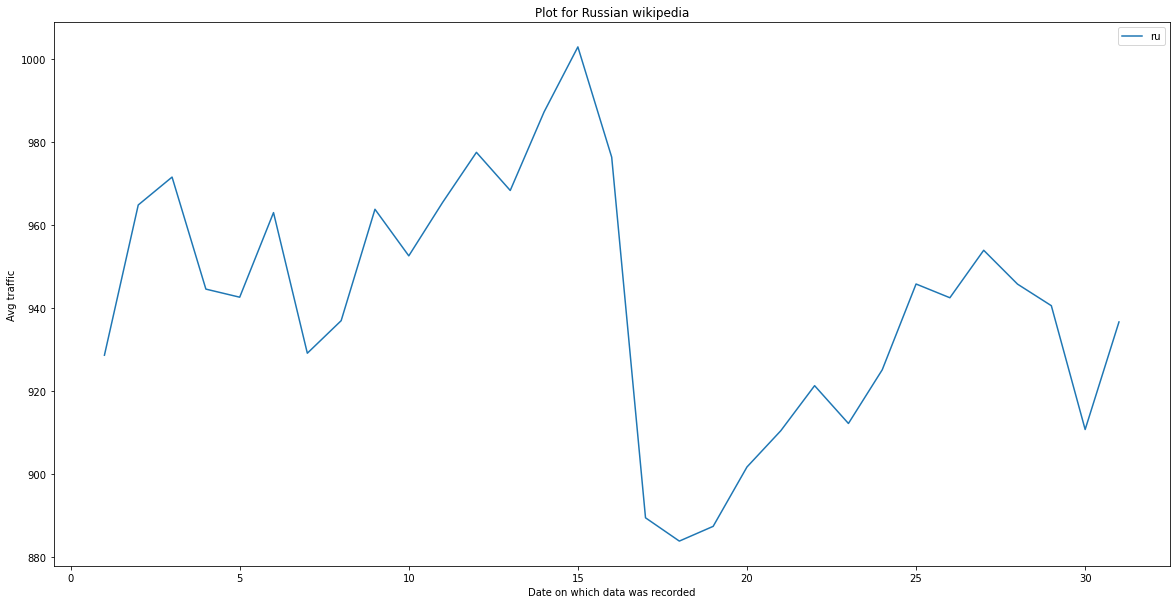

In [23]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["ru"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['day'] = copied_avg_views_per_language['date'].map(lambda x: x.day)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['day'])['ru'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

# Now, we will plot individual plot for every language to understand them in deep.
copied_avg_views_per_language.plot(figsize=(20,10),title='Plot for Russian wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

Line graph shows that avg Traffic was more in the first half of the month,it was range bw 930-1000 for first half of the month.

For the later half of the month traffic came down to 880-940.

#### Bar graph for Avg Traffic / Month Day (Russian)

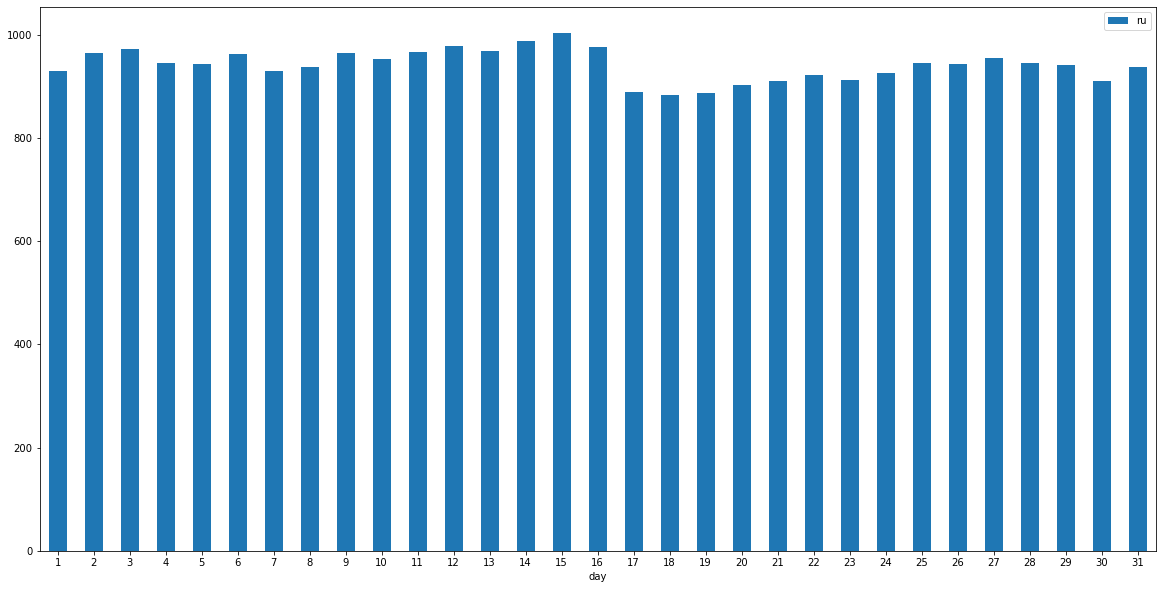

In [24]:
ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Just what we observed in the line graph , most of the bars in the first half are greater than the remaining bars of the later half.

Conclusion : Traffic was on the higher side for first half of the month.

#### Line graph for Avg Traffic / Month Day (English)

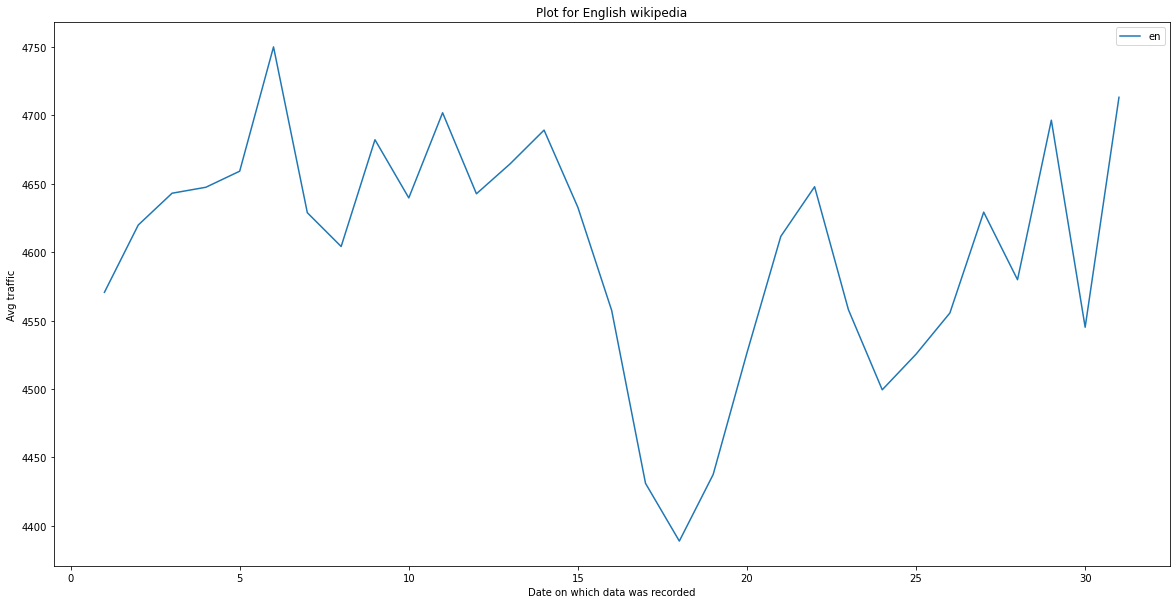

In [25]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["en"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['day'] = copied_avg_views_per_language['date'].map(lambda x: x.day)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['day'])['en'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

# Now, we will plot individual plot for every language to understand them in deep.
copied_avg_views_per_language.plot(figsize=(20,10),title='Plot for English wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

Just like what we observed in the Russian Language same scenerio can be observed as well, also as the scale has increased higher (because of the popularity of English Language) a small difference in graph will contribute to significant value.

First Half Ranges from 4570 to 4750

Second Half Ranges from 4400 to 4700.


#### Bar graph for Avg Traffic / Month Day (English)

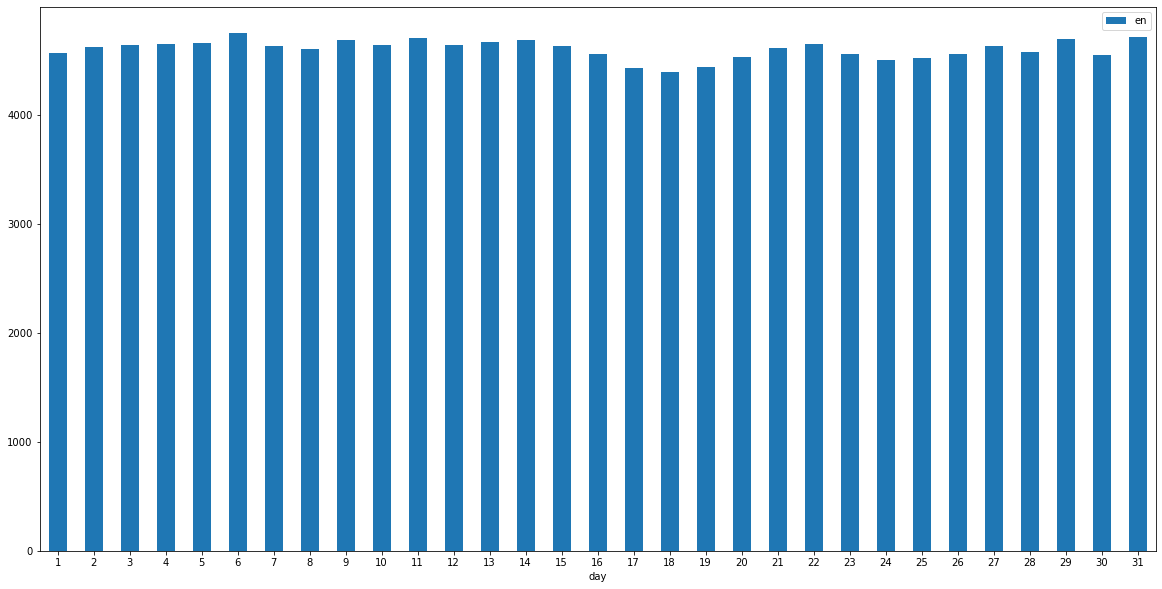

In [26]:
ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

A bent can be observed at day 15, day 22 and at day 30. These are quite significant bents as compare to first half of the month thus it can be interpret that here as well first half has more traffic as compare to second half.

Conclusion : First half of the month has more traffic compare to second half.

#### Line graph for Avg Traffic / Month Day (Spanish)

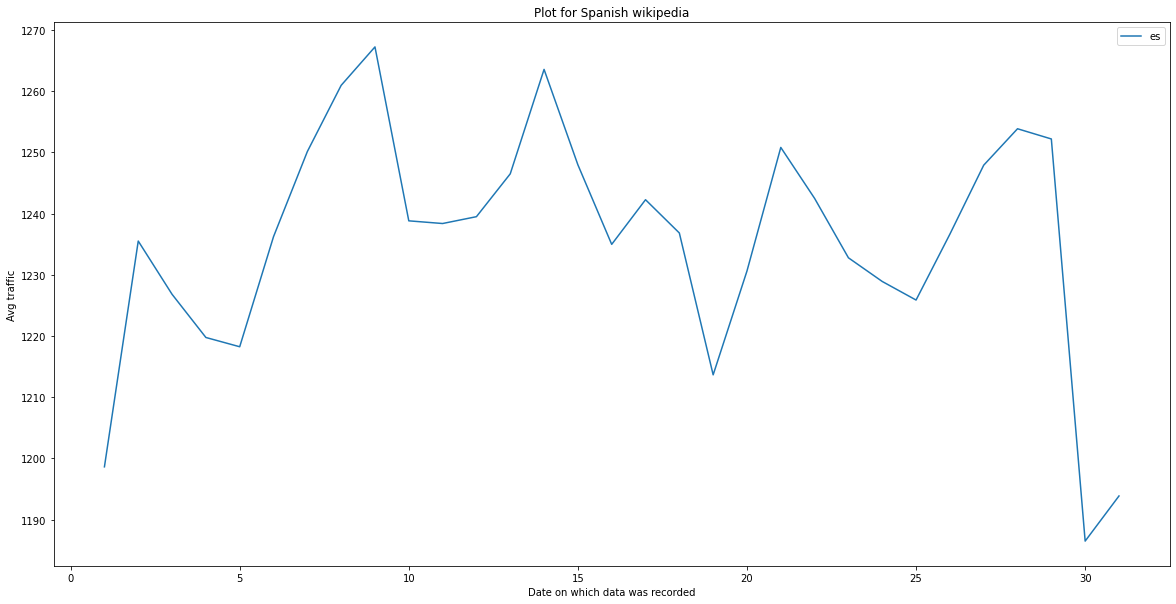

In [27]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["es"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['day'] = copied_avg_views_per_language['date'].map(lambda x: x.day)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['day'])['es'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

# Now, we will plot individual plot for every language to understand them in deep.
copied_avg_views_per_language.plot(figsize=(20,10),title='Plot for Spanish wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

Here as well it is quite similar as that of English and Russian language.

First Half of the month ranges from 1200 - 1270.

Second half of the month ranges from 1230 - 1260.

However the peaks in first half are more broader where as peaks in second half are more sharp.

This shows that traffic was on the lower side for the second half of month, but for one or two days it reaches the peak. 

#### Bar graph for Avg Traffic / Month Day (Spanish)

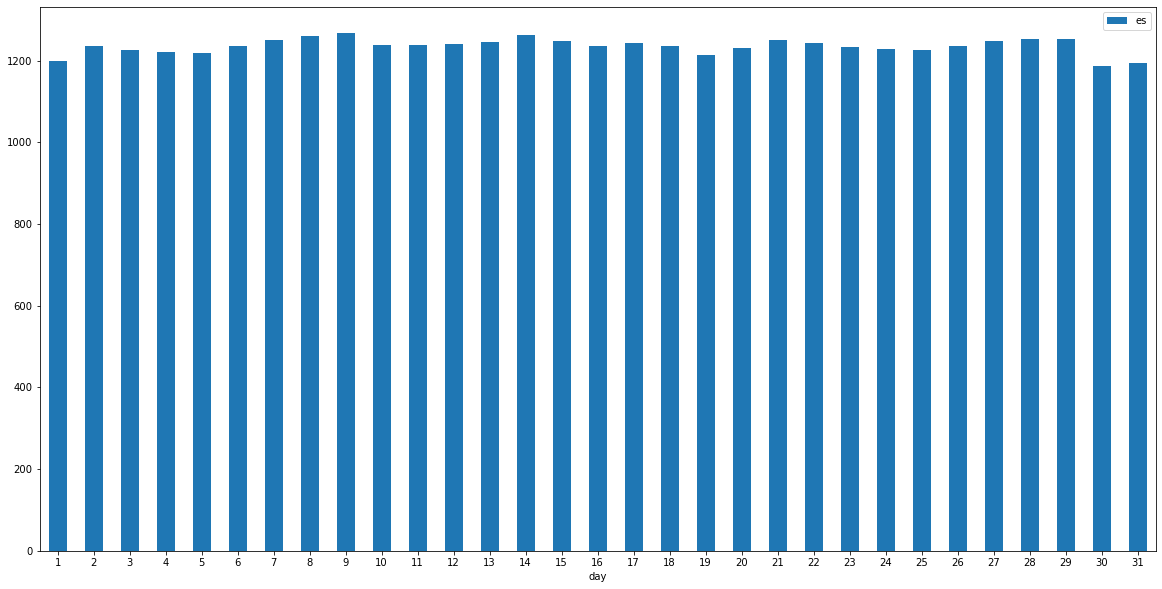

In [28]:
ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

1 curve can be observed at the start of the month at day 4, then again at day 10, day 15, day 21 and day 29.

Interestingly traffic was less at the start and end of the month.

Conclusion : Regular curves can be observed however the scale is small hence difference of 5-10 doesn't signifies much.

#### Line graph for Avg Traffic / Month Day (French)

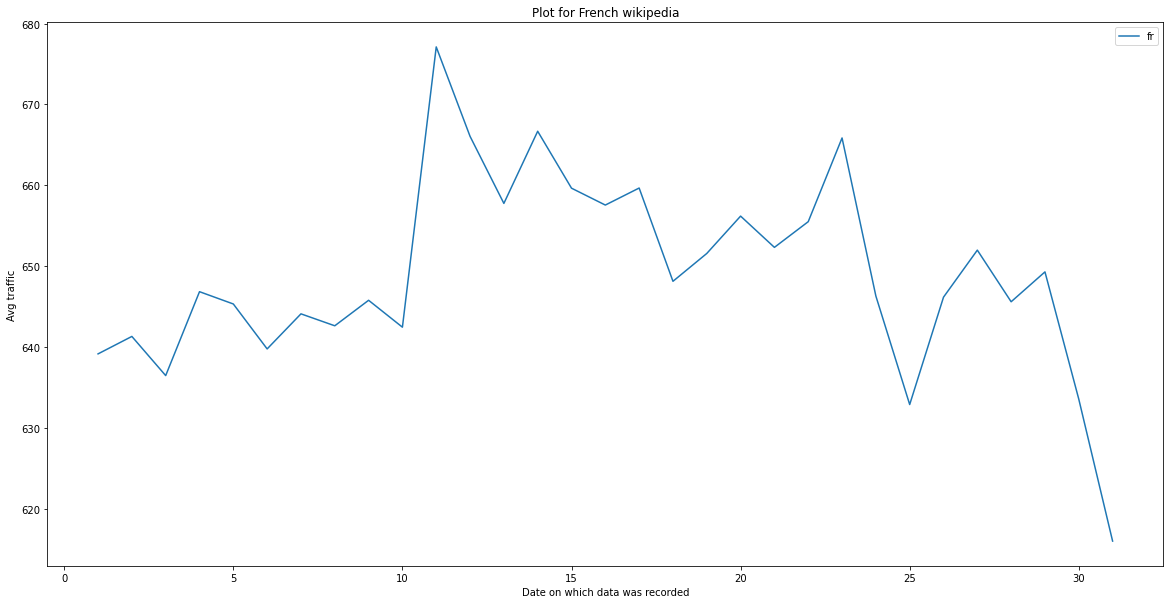

In [29]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["fr"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['day'] = copied_avg_views_per_language['date'].map(lambda x: x.day)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['day'])['fr'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

# Now, we will plot individual plot for every language to understand them in deep.
copied_avg_views_per_language.plot(figsize=(20,10),title='Plot for French wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

This graph is quite different than that of previous graphs we observed.

Interestingly the avg traffic is more in the middle days of the month, from days 10-20.

Traffic increases slowly at the starting of the month and drops sharply at the end of the month.

This is a little contradictory of what we have observed till now.

#### Bar graph for Avg Traffic / Month Day (French)

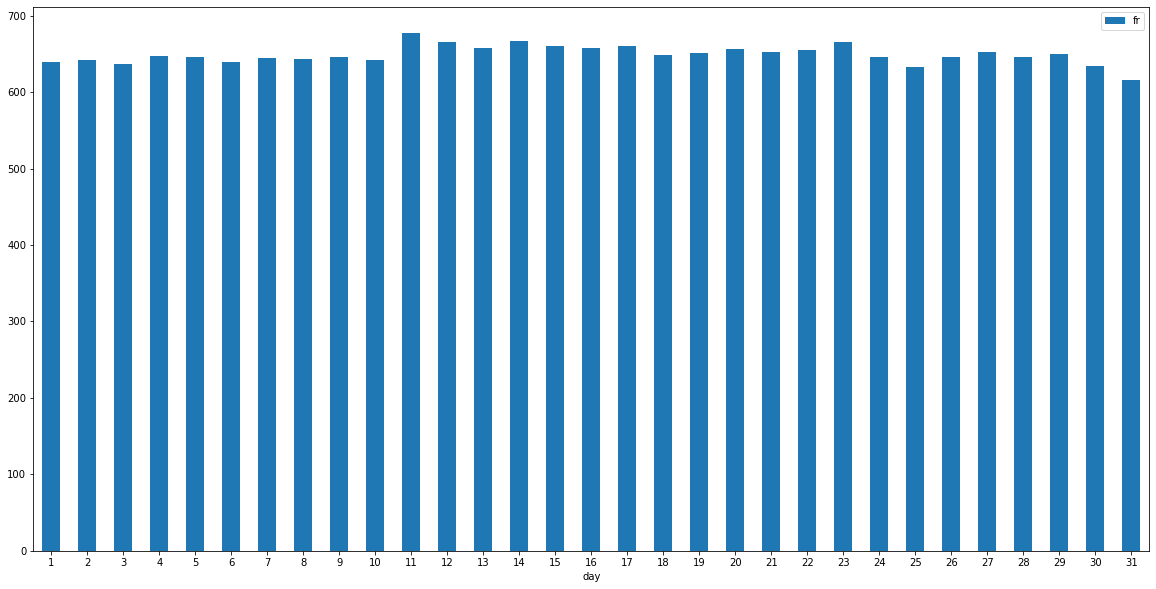

In [30]:
ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Bar graph also shows that from traffic on day 10-20 are significantly higher than traffic on rest of the days.

For the first 10 days traffic is more or less same for all days ranging around 625-640.

For the next 10 days traffic increases and ranges from 650 - 670.

For the next 10 days traffic drops signicantly from 650 to 610 .

Conclusion : Avg traffic is more in the middle days of the month.

#### Line graph for Avg Traffic / Month Day (German)

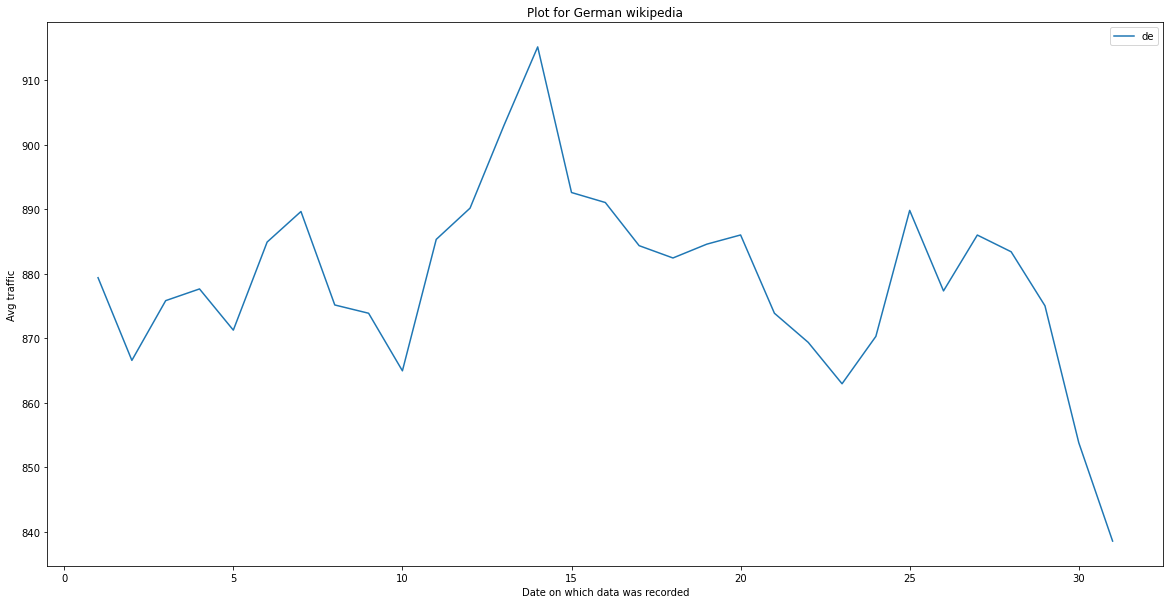

In [31]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["de"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['day'] = copied_avg_views_per_language['date'].map(lambda x: x.day)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['day'])['de'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

# Now, we will plot individual plot for every language to understand them in deep.
copied_avg_views_per_language.plot(figsize=(20,10),title='Plot for German wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

Have resemblence to French graph we observed previously, although it is not as clear as it was there but we can still say that traffic here in middle days of the months is more than rest of the days.

Small peaks can be observed at the start of the month.

Larger and broader peaks can be observed in the middle days of the months.

Sharp drop in traffic can be observed in the last week of the months.

#### Bar graph for Avg Traffic / Month Day (German)

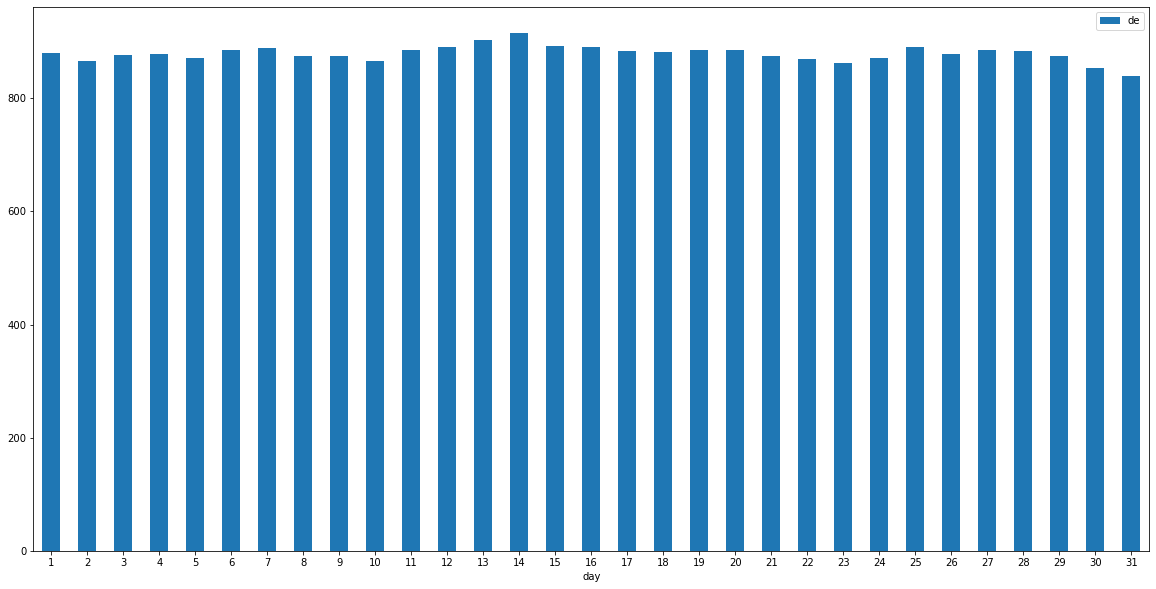

In [32]:
ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Avg Traffic for first 10 days of the month was around 840-845.

Avg Traffic for next 10 days of the month ranges around 850-900.

For the last week of the month the traffic ranges around 840.

Conclusion : German people have the tendency to read more during the middle of the months as compare to rest of the days.

#### Line graph for Avg Traffic / Month Day (Japanese)

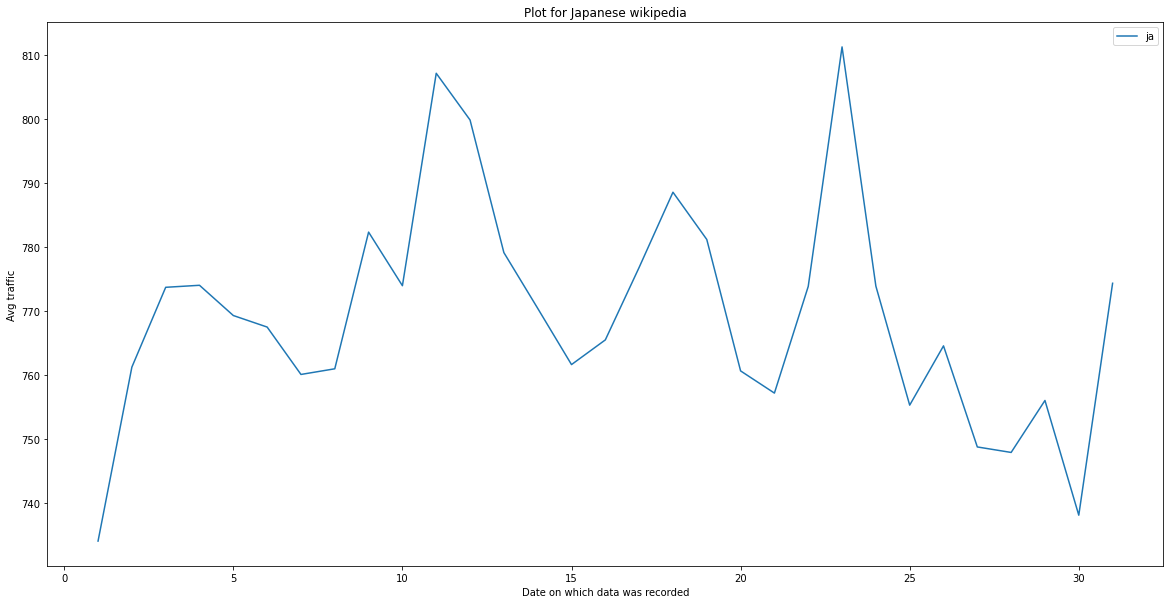

In [33]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["ja"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['day'] = copied_avg_views_per_language['date'].map(lambda x: x.day)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['day'])['ja'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

# Now, we will plot individual plot for every language to understand them in deep.
copied_avg_views_per_language.plot(figsize=(20,10),title='Plot for Japanese wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

For Japanese language we can observe that there were more peaks in the middle of the month.

More fluctuations can be seen in the middle of the months.

Even here for fisrt and last 10 days of the months peaks are smaller.

#### Bar graph for Avg Traffic / Month Day (Japanese)

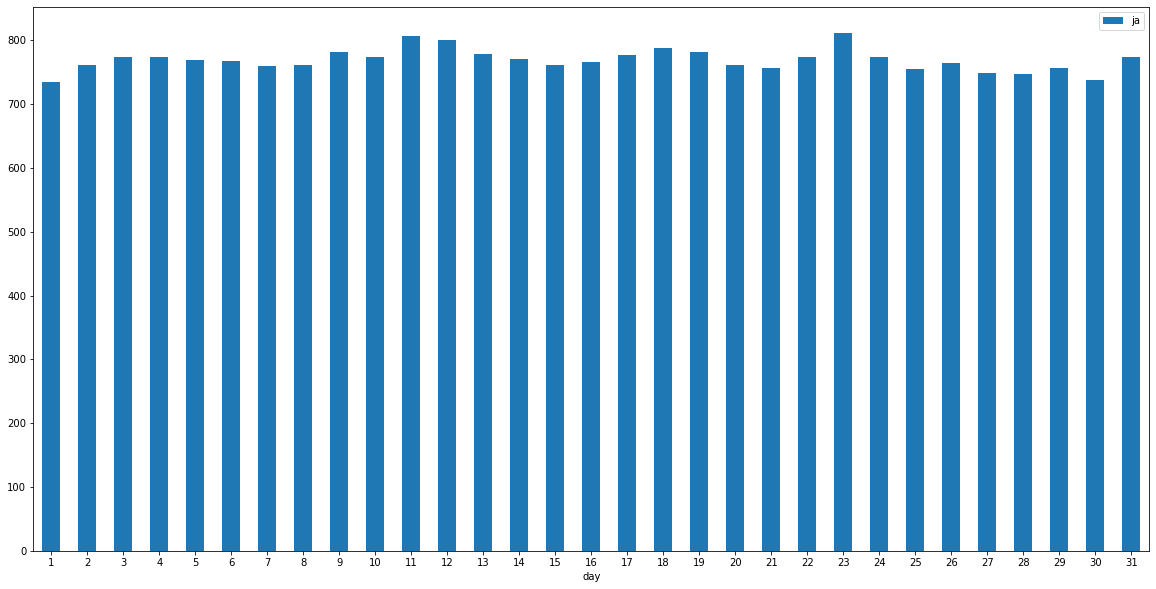

In [34]:
ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

First 10 days avg traffic ranges from 720-750.

Next 10 days avg traffic ranges from 750-800.

Significant drop in the last 10 days of the months and it again ranges from 720-750.

Conclusion : Japnaese people tends to read more in the middle days of the month.

#### Line graph for Avg Traffic / Month Day (Chinese)

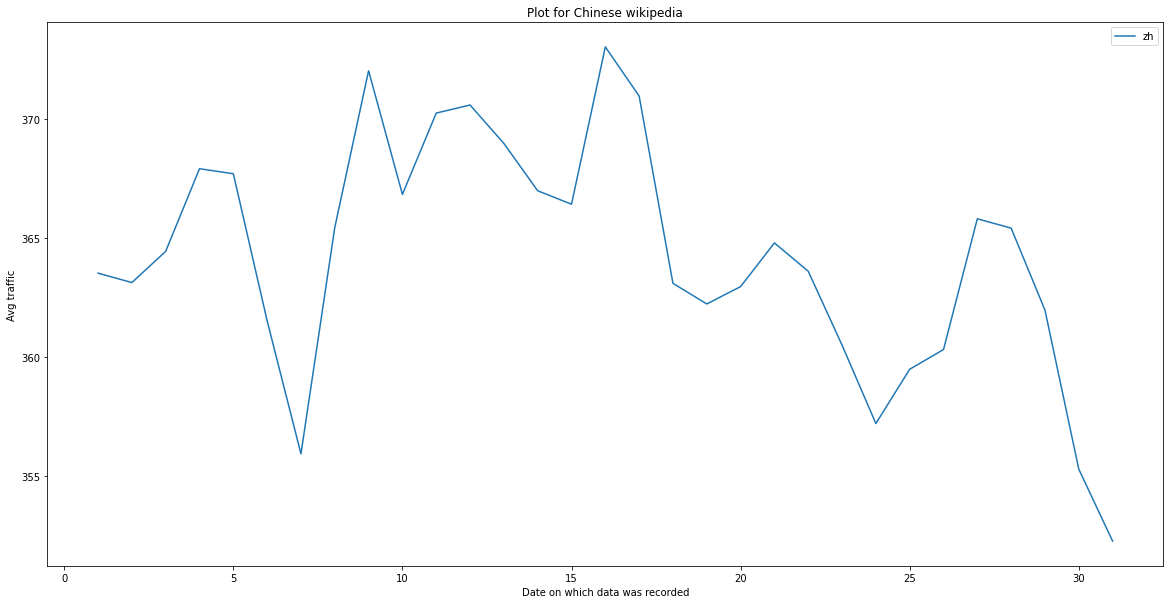

In [35]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["zh"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['day'] = copied_avg_views_per_language['date'].map(lambda x: x.day)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['day'])['zh'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

# Now, we will plot individual plot for every language to understand them in deep.
copied_avg_views_per_language.plot(figsize=(20,10),title='Plot for Chinese wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

For the Chinese language as well it is quite easy to observe that first half more avg views as compare to later half. More peaks are there in the first half.

First Half avg Traffic Ranges from 365-375 

Second Half avg Traffic Ranges from 350-360.


#### Bar graph for Avg Traffic / Month Day (Chinese)

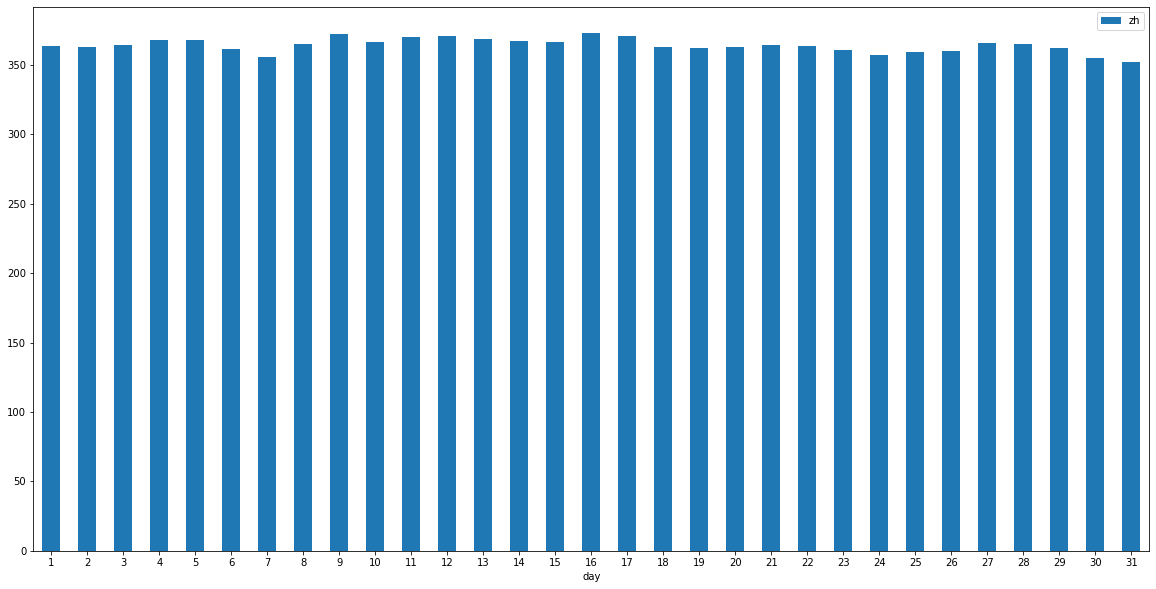

In [36]:
ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Except the last 4-5 days of the month, the traffic on rest of the days of 2nd half of the month is less than avg traffic of first half of the month.

Conclusion: We can interpret that for Chinese Language the traffic is more in first half of the month.

#### Line graph for Avg Traffic / Month Day (www)

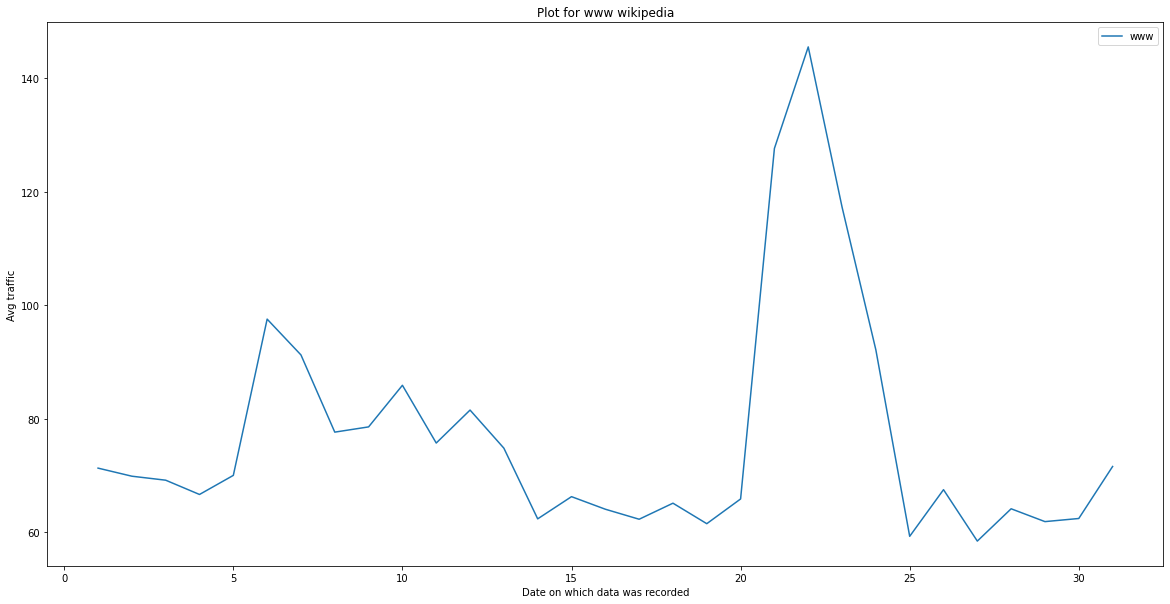

In [37]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["www"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['day'] = copied_avg_views_per_language['date'].map(lambda x: x.day)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['day'])['www'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

# Now, we will plot individual plot for every language to understand them in deep.
copied_avg_views_per_language.plot(figsize=(20,10),title='Plot for www wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

This graph doesn't resemble any of the previous graph , here a very sharp increase in traffic can be observed from day 20-25.

However , as the scale is small as compare to rest of the graphs we cannot says anything conclusive here.

#### Bar graph for Avg Traffic / Month Day (www)

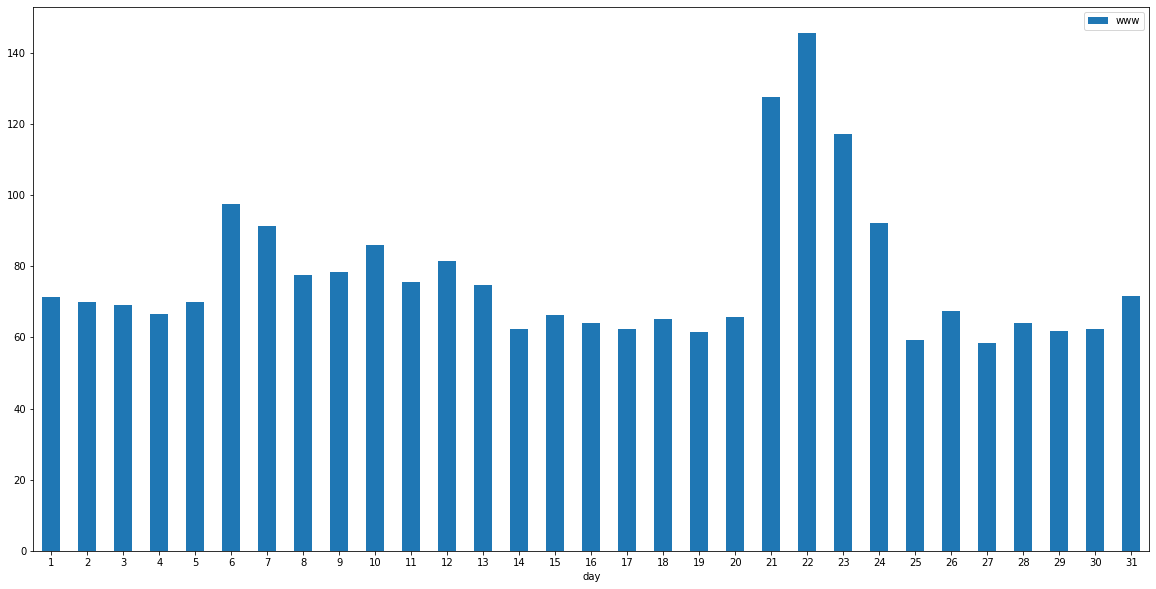

In [38]:
ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Except days 21-25 and days 6-7 there isn't much difference in the traffic for rest of the days.

Conclusion : Although 2 peaks can be observed in the graph but still nothing conclusive can be interpret.

#### Line graph for Avg Traffic / Month Day (Commons)

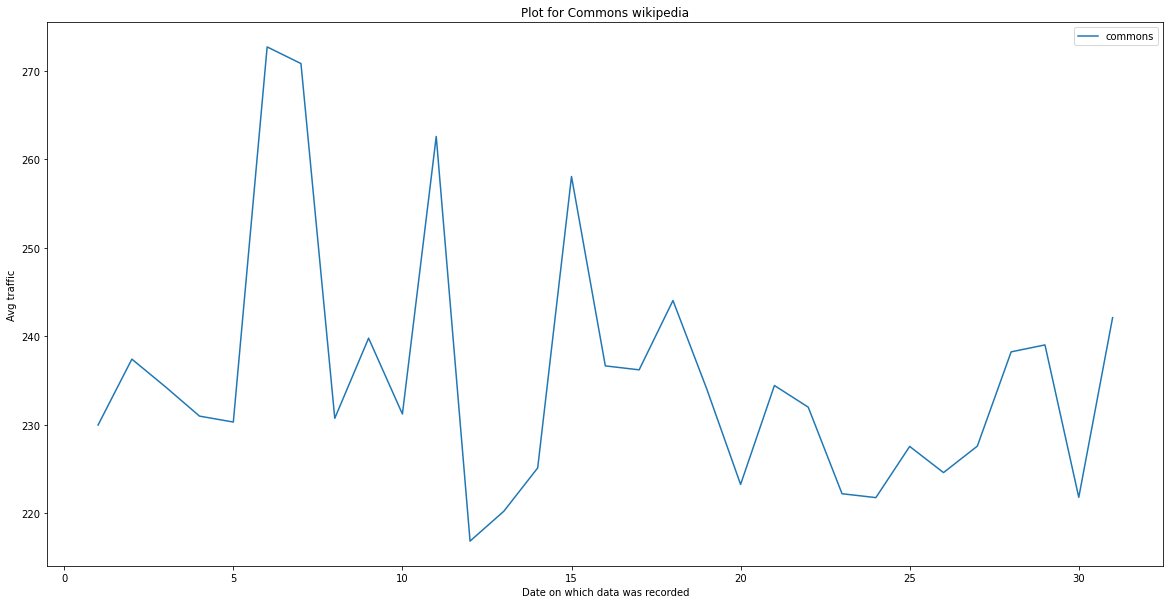

In [39]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["commons"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['day'] = copied_avg_views_per_language['date'].map(lambda x: x.day)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['day'])['commons'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

# Now, we will plot individual plot for every language to understand them in deep.
copied_avg_views_per_language.plot(figsize=(20,10),title='Plot for Commons wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

For the remaining pages it can be observed that avg views fluctuated very much but still avg views for first half of the month are more than later half of the month.

#### Bar graph for Avg Traffic / Month Day (Commons)

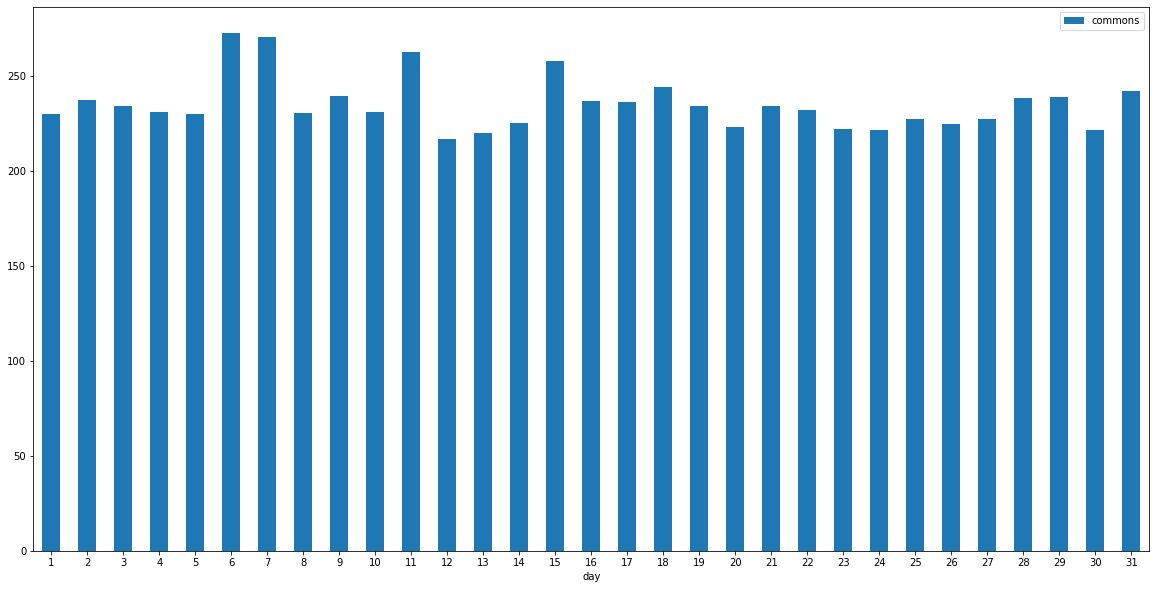

In [40]:
ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

As determined by the Line Graph data fluctuate more in first half of the month but still avg views in first half of the month is greater than 2 half of the month.

Conclustion : Traffic for rest of the pages has more traffic in first half of month as compare to second half of the month.

#### We can say that for english, russian , spanish and chinese more traffic was observed for first half of the months and for german, french , japanese more traffic was observed in the middle days of the months. For Commons pages as well we can say that first half draws more number of views as compare to later half.

### 2.1.5.2 Avg Views / Week days

#### Bar graph for Avg Traffic / Week Day (Russian)

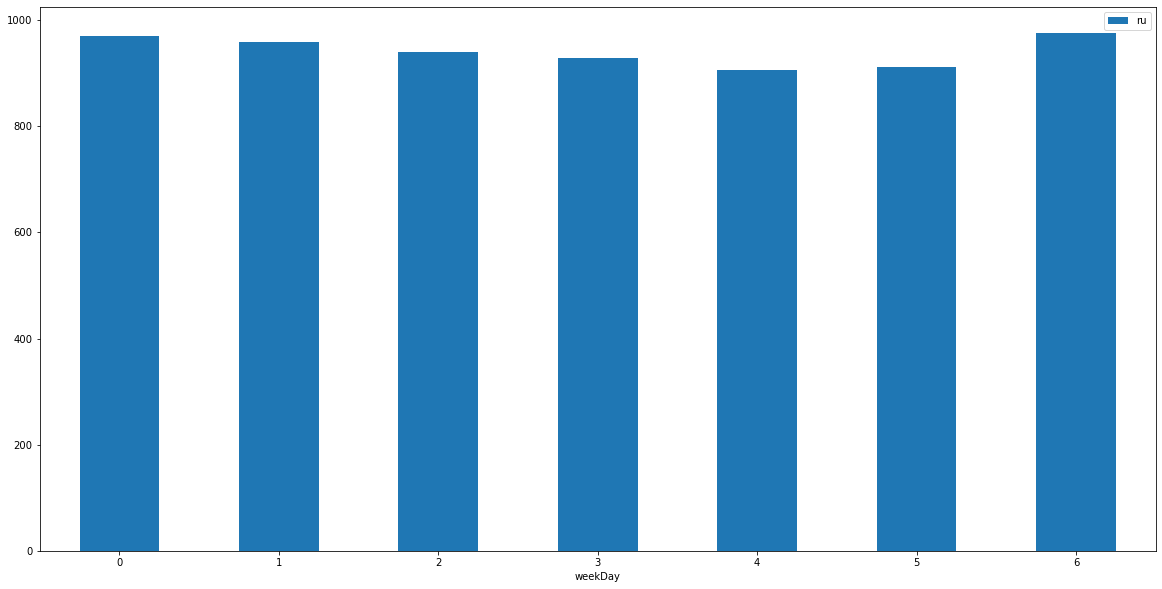

In [41]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["ru"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['weekDay'] = copied_avg_views_per_language['date'].map(lambda x: x.weekday())
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['weekDay'])['ru'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

On week days it was observed that avg traffic decreases as the week progresses , however on weekend traffic starts increasing which is quite obvious as people get enough time to go through there phones , laptops etc.

#### Bar graph for Avg Traffic / Week Day (English)

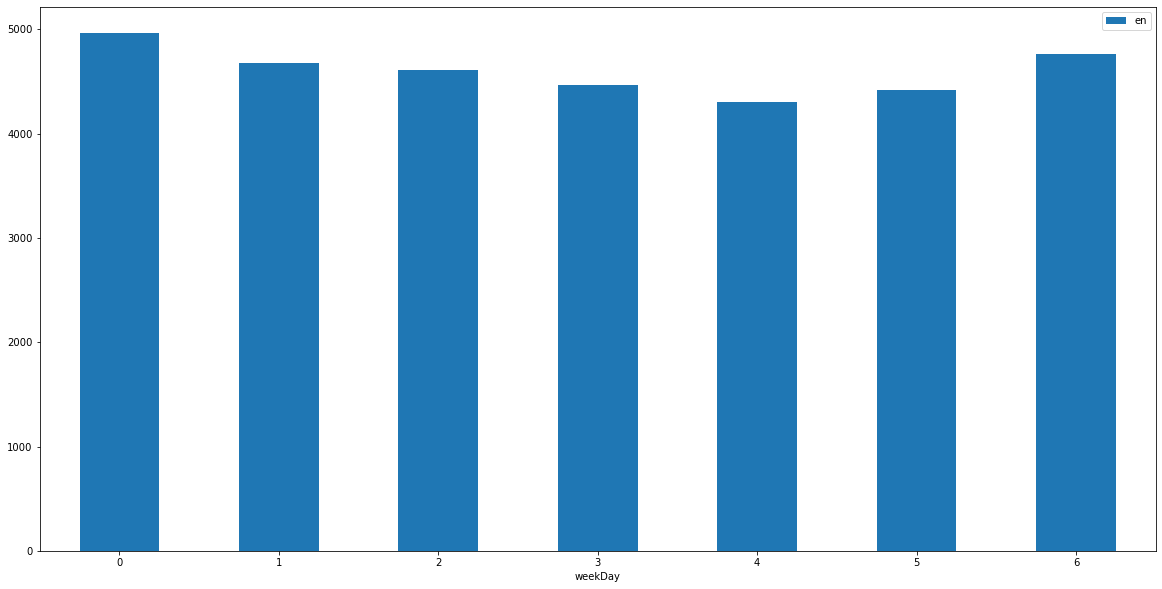

In [42]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["en"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['weekDay'] = copied_avg_views_per_language['date'].map(lambda x: x.weekday())
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['weekDay'])['en'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Same pattern that was observed for Russian Language was observed here as well just the scale is higher here.

#### Bar graph for Avg Traffic / Week Day (Spanish)

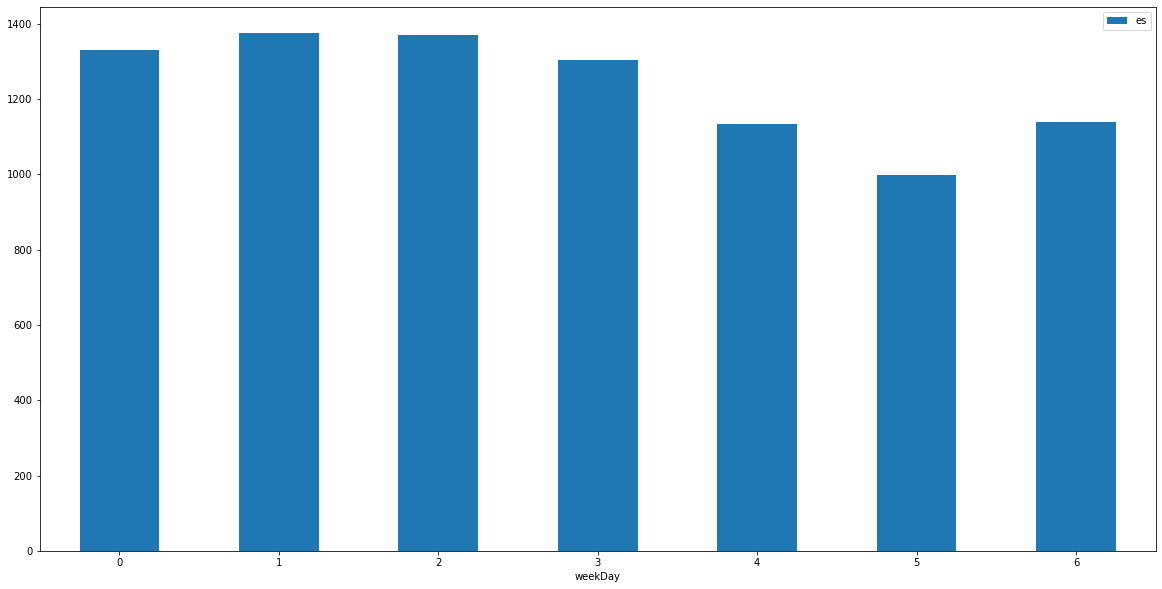

In [43]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["es"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['weekDay'] = copied_avg_views_per_language['date'].map(lambda x: x.weekday())
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['weekDay'])['es'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Interestingly here monday doesn't have the highest traffic among week days. On Tuesday, the highest traffic was observed than it decreases as the week progresses and on Sunday the avg traffic increases.

Also Saturday doesn't have a higher avg traffic as compare to friday which was observed in the previous graphs.

Conclusion: Spanish people tends to spend less time on articles/web pages on Saturday as compare to rest of the days.

#### Bar graph for Avg Traffic / Week Day (French)

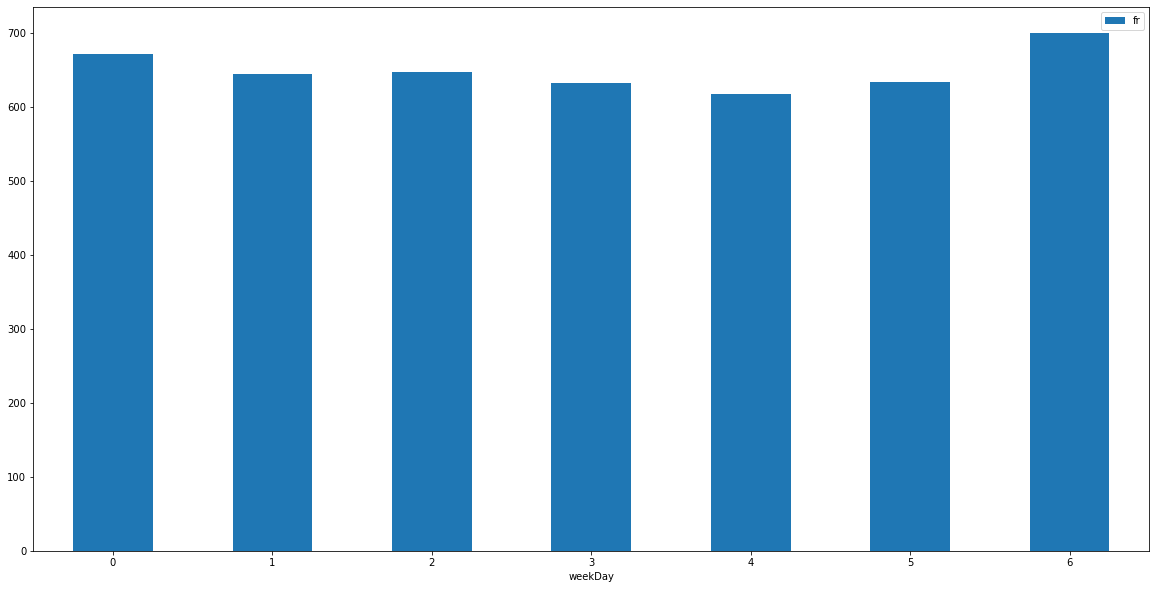

In [44]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["fr"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['weekDay'] = copied_avg_views_per_language['date'].map(lambda x: x.weekday())
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['weekDay'])['fr'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Quite similar pattern to that we observed in English and Russian Language. On weekend the traffic starts increasing.

#### Bar graph for Avg Traffic / Week Day (German)

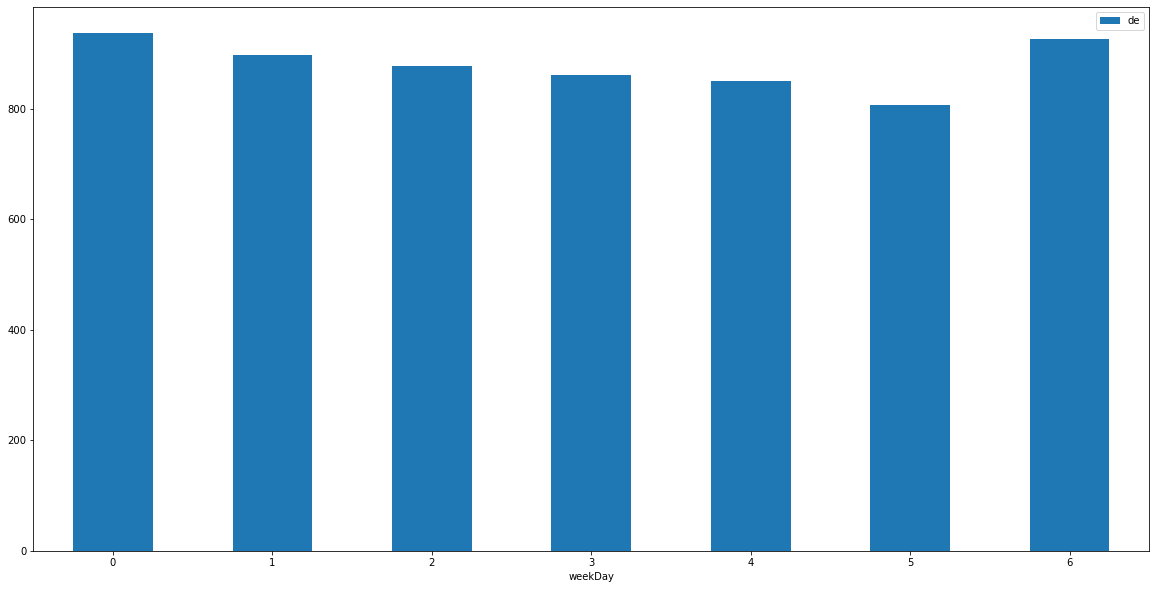

In [45]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["de"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['weekDay'] = copied_avg_views_per_language['date'].map(lambda x: x.weekday())
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['weekDay'])['de'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

For weekdays the traffic follows same pattern as that of English,Russian,French but over the weekends we observed that on Saturday the traffic doesn't increase , quite similar to that of spanish and then on Sunday traffic achieves the highest avg.

Conclusion : German people tends to spend less time on articles/web pages on Saturday as compare to rest of the days.

#### Bar graph for Avg Traffic / Week Day (Japanese)

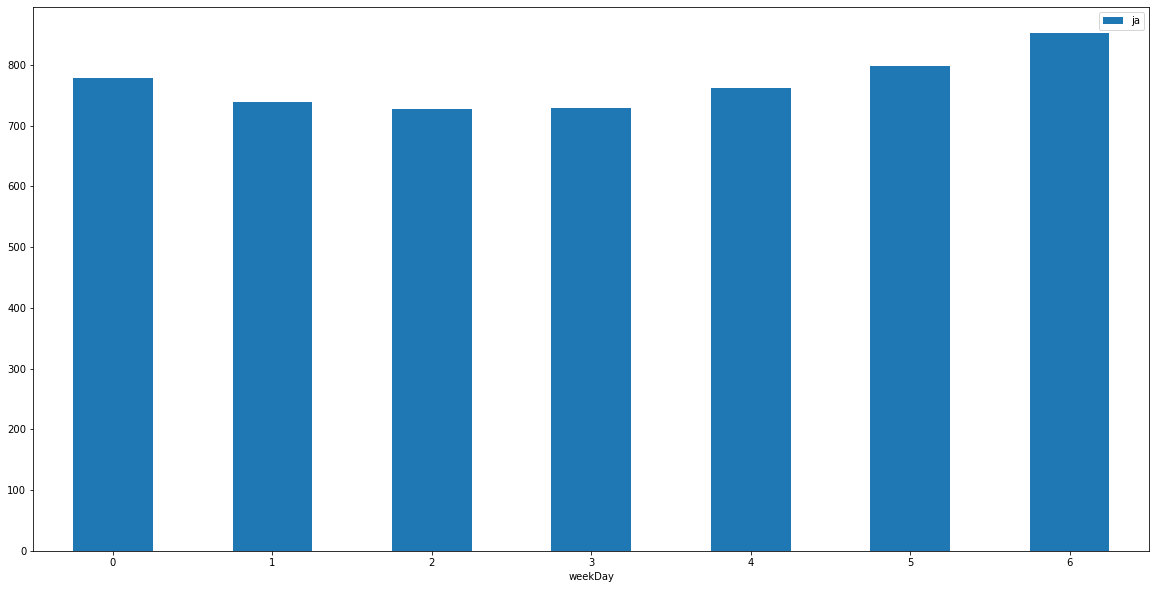

In [46]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["ja"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['weekDay'] = copied_avg_views_per_language['date'].map(lambda x: x.weekday())
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['weekDay'])['ja'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

This is really interesting, so from monday to wednesday the traffic follows same pattern like most of the previous language.

Then thursday was able to achieve the same avg as that of wednesday and for friday,saturday and sunday the traffic starts increasing. 

Conclusion : Traffic starts increases from Friday for Japanese language,

#### Bar graph for Avg Traffic / Week Day (Chinese)

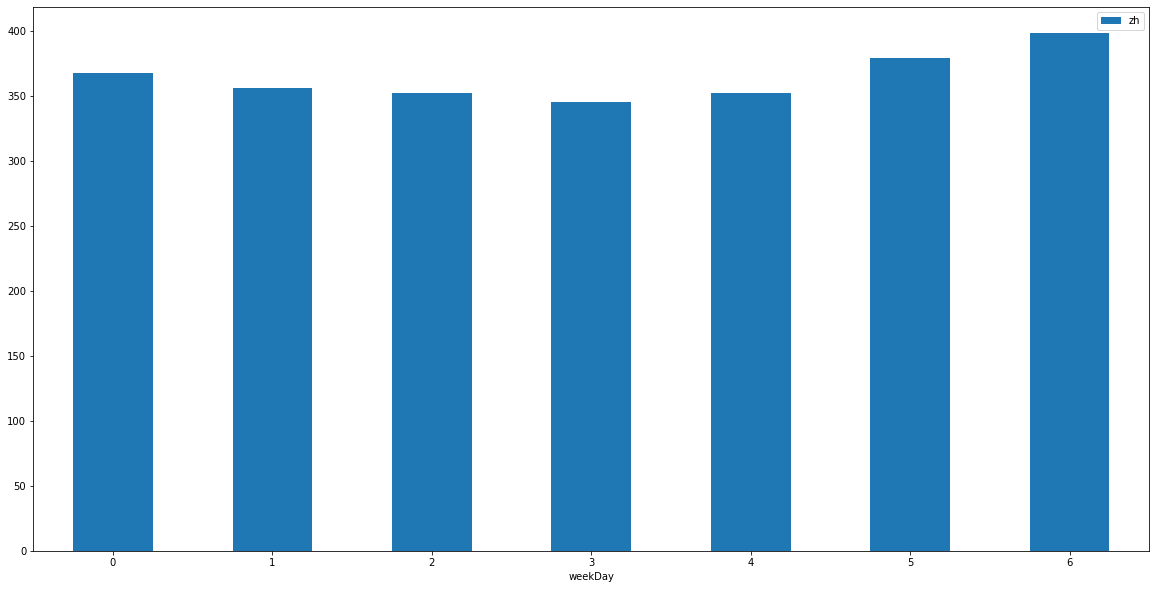

In [47]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["zh"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['weekDay'] = copied_avg_views_per_language['date'].map(lambda x: x.weekday())
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['weekDay'])['zh'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Quite similar pattern to that of Japanese Language. The traffic started increasing from Friday and keep increasing as the weekend progresses.

#### Bar graph for Avg Traffic / Week Day (www)

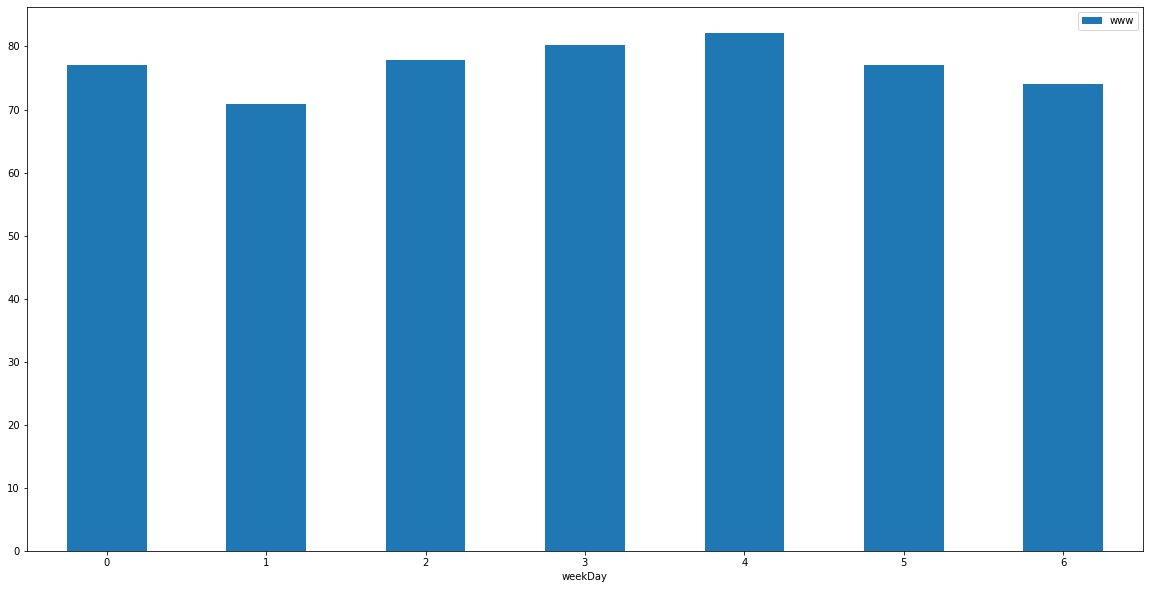

In [48]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["www"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['weekDay'] = copied_avg_views_per_language['date'].map(lambda x: x.weekday())
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['weekDay'])['www'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

For www pages it doesn't follow as specific pattern , also since the scale is small nothing conclusive can be said.

#### Bar graph for Avg Traffic / Week Day (Commons)

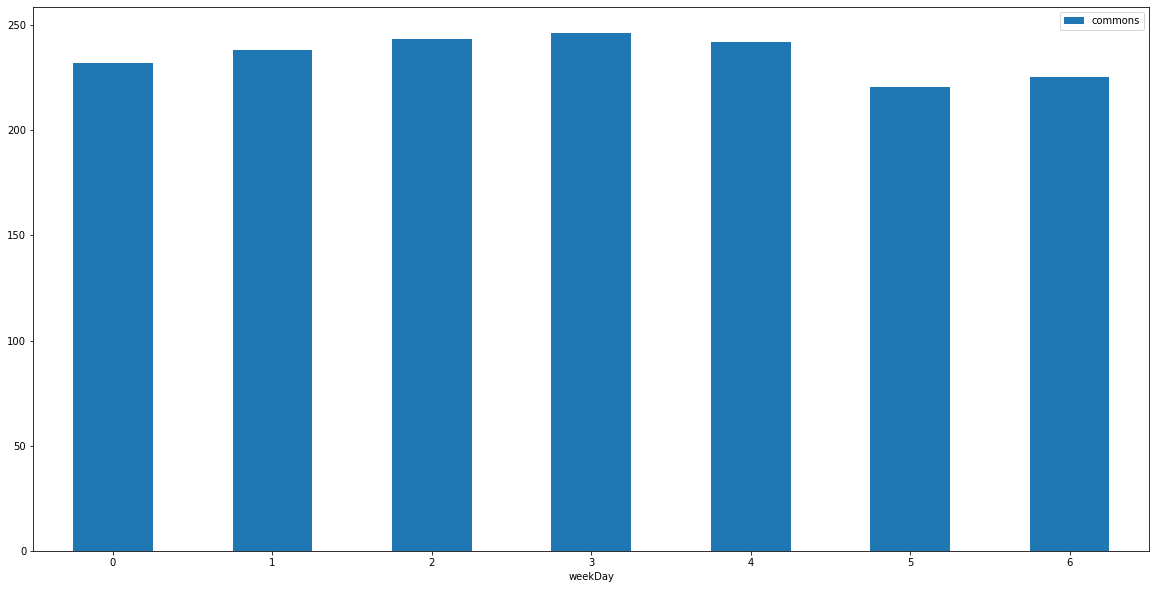

In [49]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["commons"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['weekDay'] = copied_avg_views_per_language['date'].map(lambda x: x.weekday())
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['weekDay'])['commons'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

For weekends the traffic drawn by these pages are very less as compare to rest of the pages. 

### 2.1.5.3 Avg Views / Month

#### Bar graph for Avg Traffic / Month (Russian)

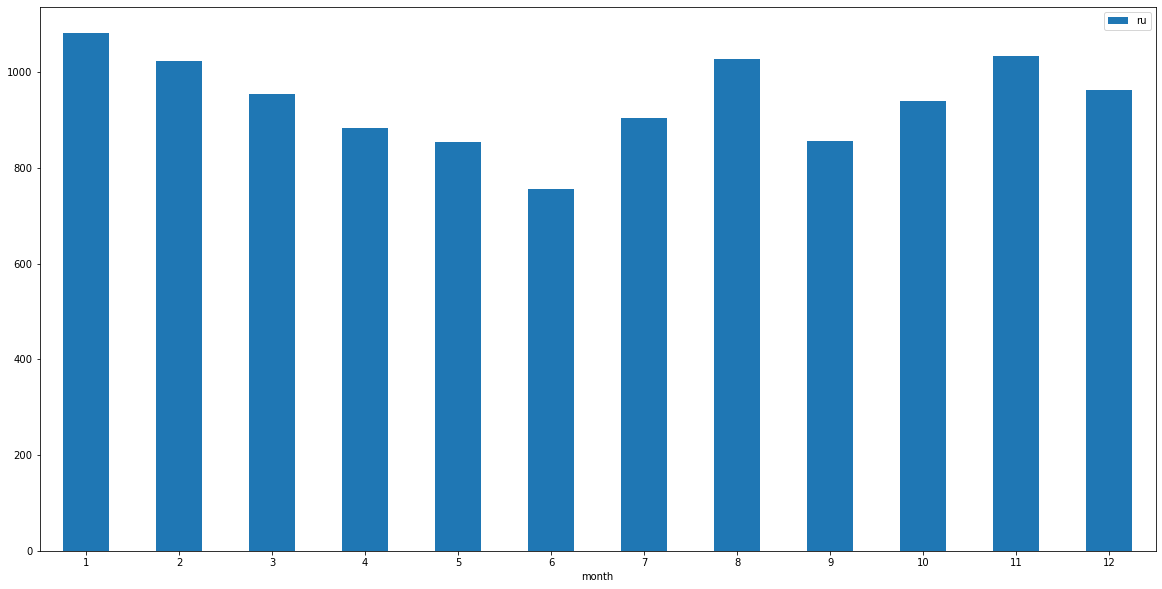

In [50]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["ru"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['month'] = copied_avg_views_per_language['date'].map(lambda x: x.month)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['month'])['ru'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

It was observed that over the first half of the year January had the highest avg traffic which decreases as the year progresses.

Then on July and August the traffic agains starts increasing, this is due to fact that on July/16 to Aug/16 we observed a very sharp curve, that resulted in a higher average overall.

Then on September the traffic came to its normal value and it increases as the year progresses


#### Bar graph for Avg Traffic / Month (English)

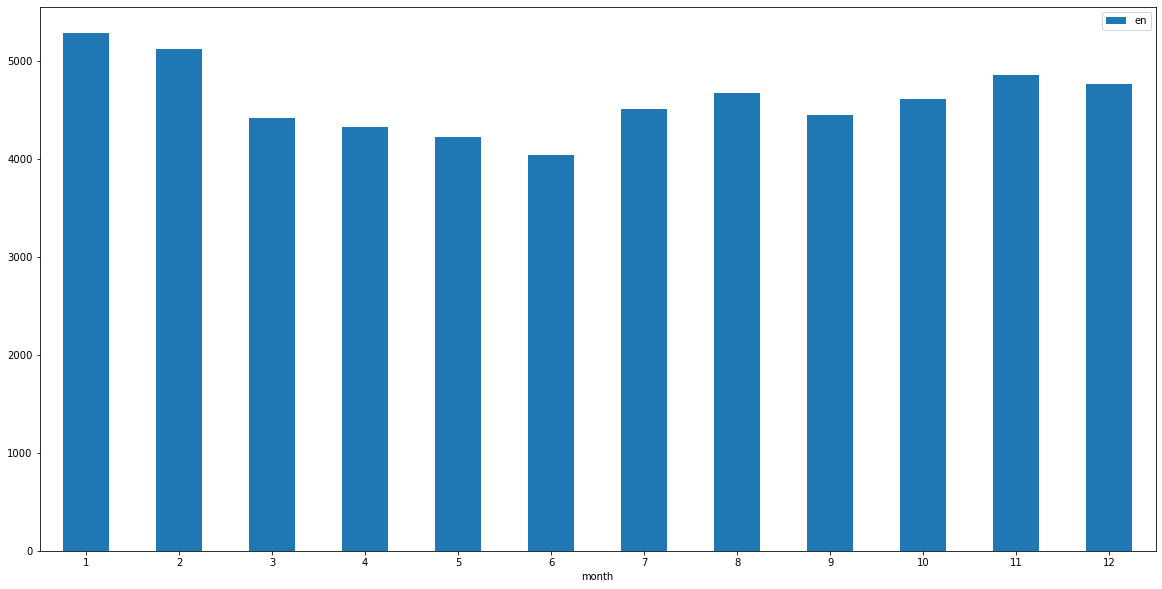

In [51]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["en"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['month'] = copied_avg_views_per_language['date'].map(lambda x: x.month)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['month'])['en'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Very similar to what we observed for Russian language.

July and Aug draws the quite high traffic because of the event in July 16 and Aug 16. Apart from that in the first half as the year progresses the avg traffic decreases and for the second half of the year(after August) the avg traffic increases as year progress

#### Bar graph for Avg Traffic / Month (Spanish)

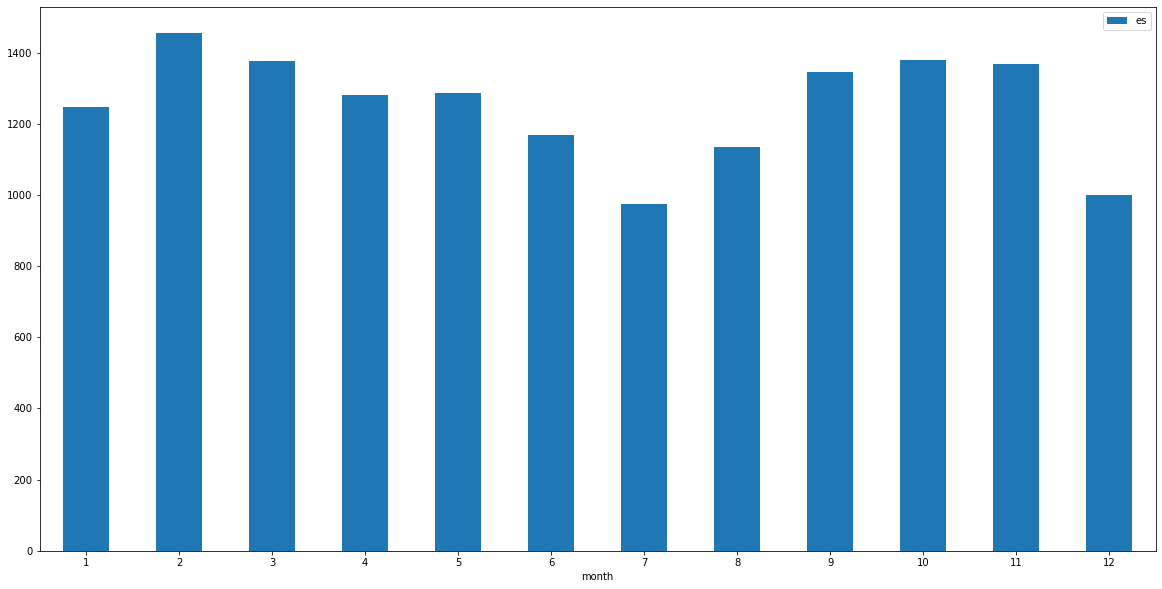

In [52]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["es"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['month'] = copied_avg_views_per_language['date'].map(lambda x: x.month)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['month'])['es'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Here December and January draws less traffic as compare to its neighbour months. 

Christmas and New Year could be one of the reason for this drop in the avg traffic.

Remember for weekdays graph on Saturdays as well the traffic dropped significantly 

#### Bar graph for Avg Traffic / Month (French)

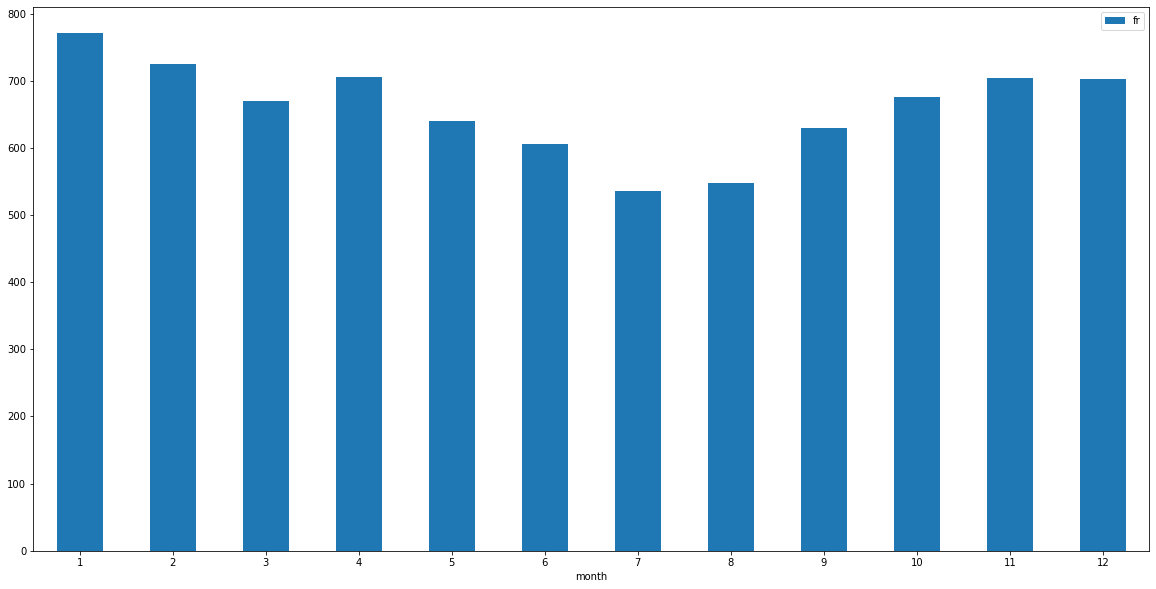

In [53]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["fr"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['month'] = copied_avg_views_per_language['date'].map(lambda x: x.month)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['month'])['fr'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

The pattern here has some similarity with that of Russian and English language. For the first half of the year the traffic decreases except that a high traffic was observed for the month of april.

From July onwards the traffic kept increasing as the year progress and finally on December the traffic dropped but not much.

#### Bar graph for Avg Traffic / Month (German)

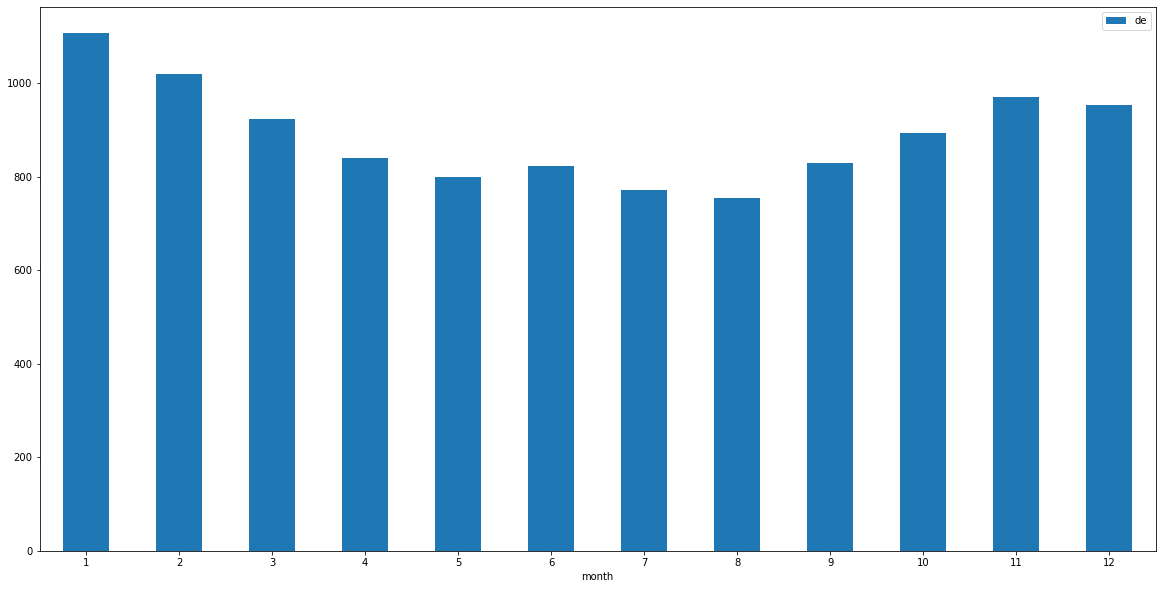

In [54]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["de"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['month'] = copied_avg_views_per_language['date'].map(lambda x: x.month)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['month'])['de'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Quite similar to that of French graph here as well traffic decreases in the first half of the year and then increses on the later half of the year. 

On december a slight drop in traffic can be observed here as well possibly Christmas could be one of the reason.

#### Bar graph for Avg Traffic / Month (Japanese)

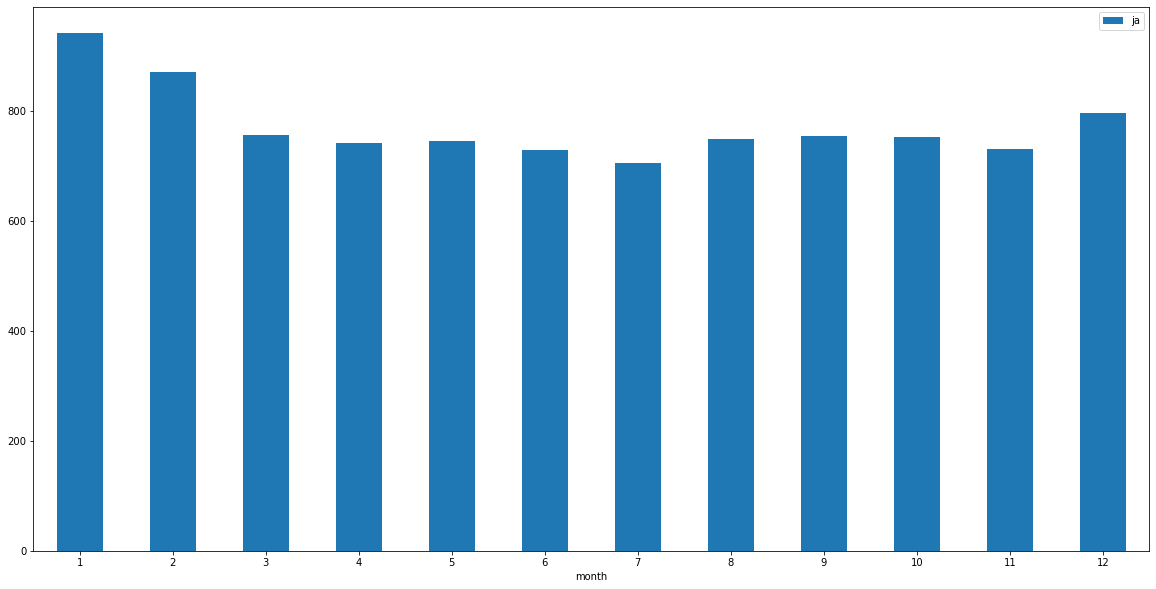

In [55]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["ja"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['month'] = copied_avg_views_per_language['date'].map(lambda x: x.month)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['month'])['ja'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Januagry and February draws the highest traffic in Japanese language as compare to rest of the months.

For rest of the months the traffic was quite stable. From Mar to Jun the avg traffic was almost same. 

A slight decrease observed in July and then from Aug to Nov the avg traffic was almost same, slight decrease in november and then traffic increases for the month of December.

#### Bar graph for Avg Traffic / Month (Chinese)

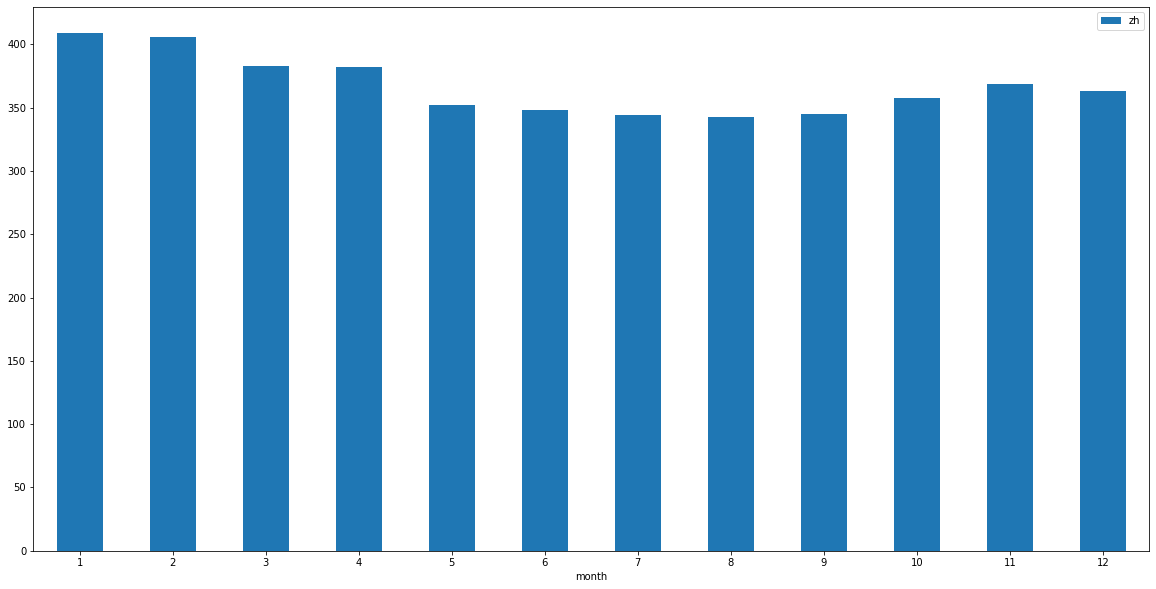

In [56]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["zh"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['month'] = copied_avg_views_per_language['date'].map(lambda x: x.month)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['month'])['zh'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Just what we observed in Chinese weekdays graph it was almost like Japanese week here as well the month patter are almost same.

Conclusion : Chinese and Japanese follows the same pattern.

#### Bar graph for Avg Traffic / Month (www)

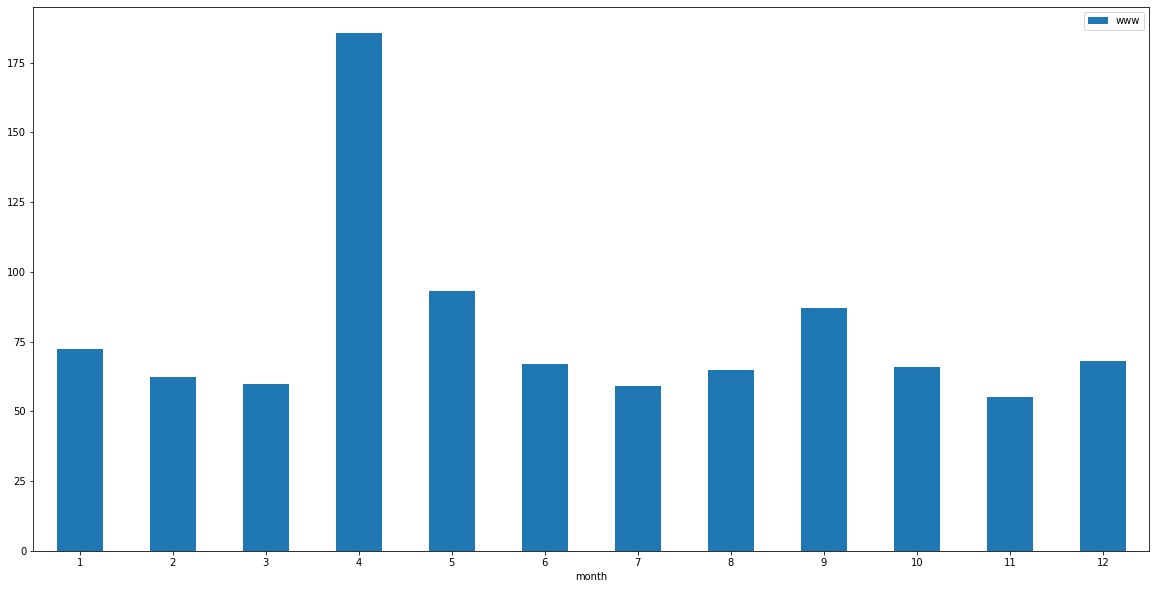

In [57]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["www"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['month'] = copied_avg_views_per_language['date'].map(lambda x: x.month)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['month'])['www'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Here april was able to draw a very high avg traffic. For rest of the months the avg traffic ranges from 60-75.

#### Bar graph for Avg Traffic / Month (Commons)

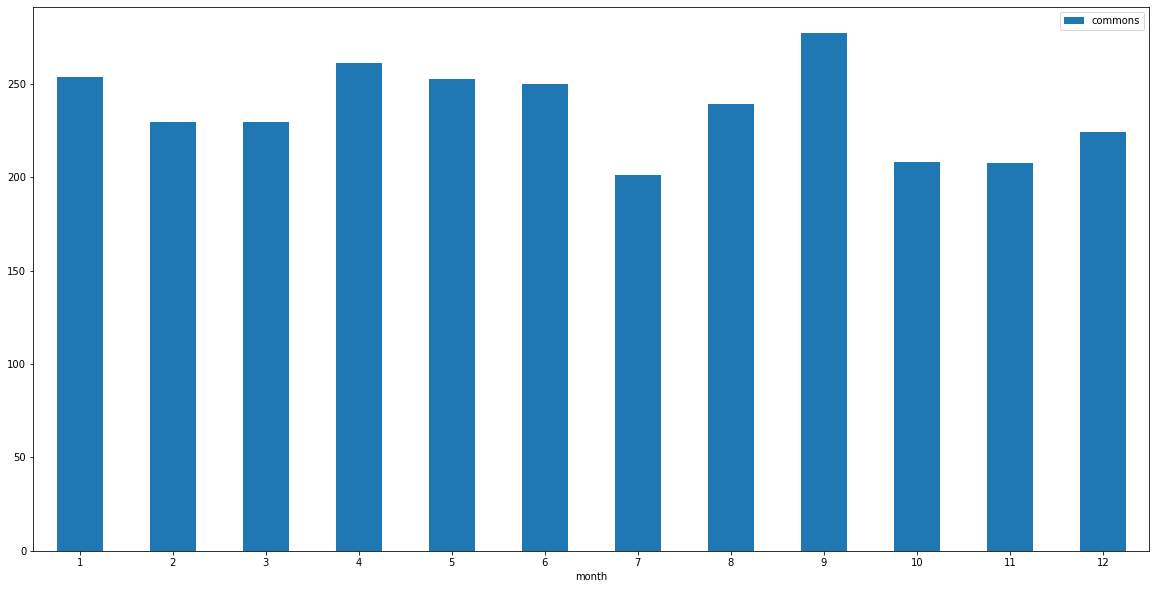

In [58]:
copied_avg_views_per_language = pd.DataFrame(avg_views_per_language.loc["commons"])
copied_avg_views_per_language['date'] = copied_avg_views_per_language.index
copied_avg_views_per_language['date'] = copied_avg_views_per_language['date'].astype('datetime64[ns]')
copied_avg_views_per_language['month'] = copied_avg_views_per_language['date'].map(lambda x: x.month)
copied_avg_views_per_language = copied_avg_views_per_language.groupby(['month'])['commons'].mean()

copied_avg_views_per_language = pd.DataFrame(copied_avg_views_per_language)

ax = copied_avg_views_per_language.plot.bar(rot=0,figsize=(20, 10))

Observing quarterly :

    Jan-Mar :- Traffic decreases as the month increases 
    
    Apr-Jun :- Increase in traffic was observed in Apr as compare to march, and the same avg was maintained for the whole quarter.
    
    July-Sept :- Significant drop was observed as we enter this 3rd quarter. The traffic increases again as the quarter progresses.
    
    Oct-Dec :- Again a significant drop was observed in the first month of this quarter and traffic remains same for november as well, a slight increase in traffic was observed for December.

#### For zh,ja,fr,de,en,ru,es all of them we found that traffic is more in the first half of the year or lesser the month number more is the traffic

### 2.1.5.4 Plotting individual language's traffic , autocorrelation plot and Fourier Transform

#### For Russian

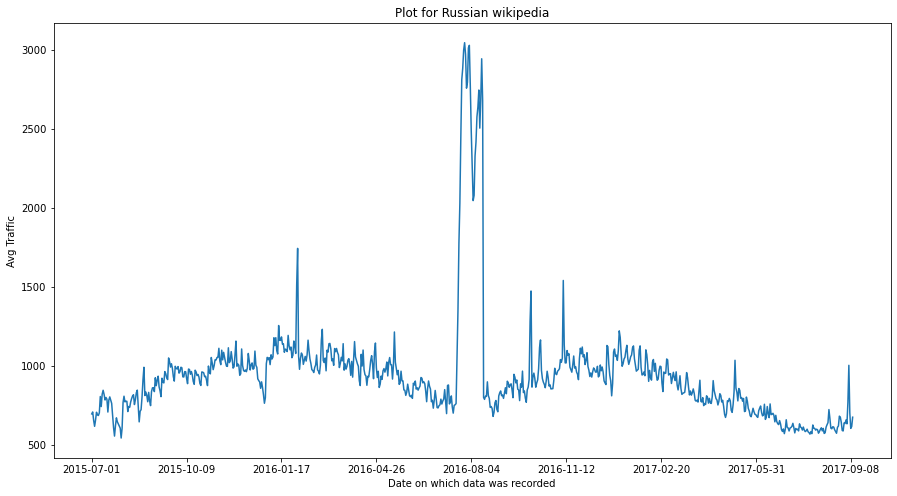

In [67]:
# Now, we will plot individual plot for every language to understand them in deep.
avg_views_per_language.loc['ru'].transpose().plot(figsize=(15,8),title='Plot for Russian wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg Traffic')
plt.show()

We can not find any weekly or monthly seasonality here but after 07/2015 almost same curve was observed at 08/2016. Thus we can say there is some yearly seasonality present.

Let us now see the autocorrelation graph.

#### Autocorrelation plot

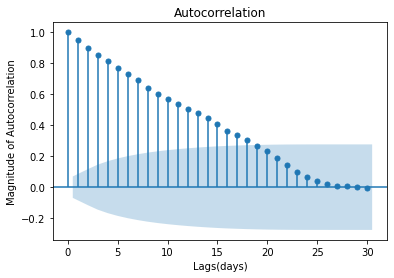

In [68]:
from statsmodels.graphics.tsaplots import plot_acf

x=plot_acf(avg_views_per_language.transpose().ru,lags=30)
plt.xlabel('Lags(days)')
plt.ylabel('Magnitude of Autocorrelation')
plt.show()

The graph is continuously decreasing thus it confirms that there is no weekly seasonality present. 

#### Fourier Transform

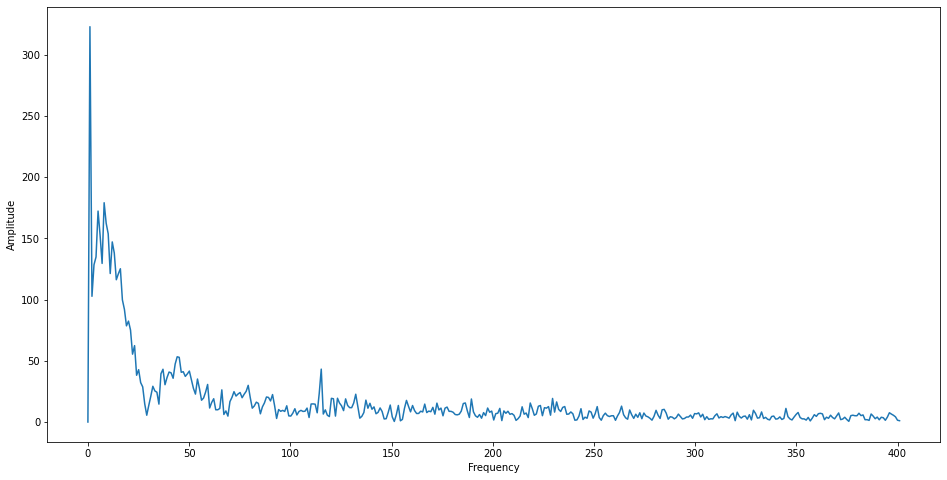

In [69]:
from scipy import fft

# Lets take a look at our data in frequency domain, we will use Fast Fourier transformation for that.
# I haven't used fft before, so these are the two links that i reffered in order to plot the fft
#https://dsp.stackexchange.com/questions/16181/matlab-remove-the-frequency-at-zero-in-fft?answertab=votes#tab-top
#https://alphabold.com/fourier-transform-in-python-vibration-analysis/

data=avg_views_per_language.transpose().ru.values[1:] # This is the data that we are going to transform to analyse the frequency domain
data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
x=fft.fft(data) #Fourier Transformation
freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
y=2/550*np.abs(x[0:803//2]) # Taking absolute values of half data points 
plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freq,y)
plt.show()

A small peak was observed at 120 days, but nothing much conclusive here as well.

#### For English

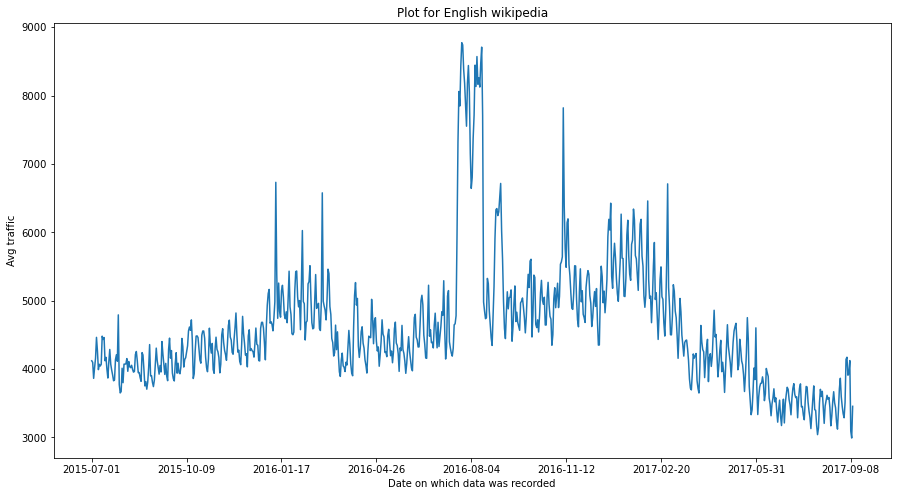

In [80]:
# Now, we will plot individual plot for every language to understand them in deep.
avg_views_per_language.loc['en'].transpose().plot(figsize=(15,8),title='Plot for English wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

The graph is almost as that of russian. We can not find any weekly or monthly seasonality here as well but the graph repeats it self after july/august. Thus we could say that yearly seasonality is there.

#### Autocorrelation plot

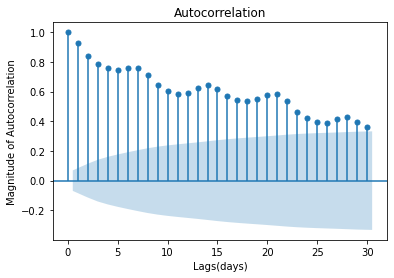

In [71]:
x=plot_acf(avg_views_per_language.transpose().en,lags=30)
plt.xlabel('Lags(days)')
plt.ylabel('Magnitude of Autocorrelation')
plt.show()

It is interesting to see that there is some weekly seasonality present in english language as displayed by the autocorrelation graph. Lag of 7 days have higher magnitude than that of lag of 6 days. 

#### Fourier Transform

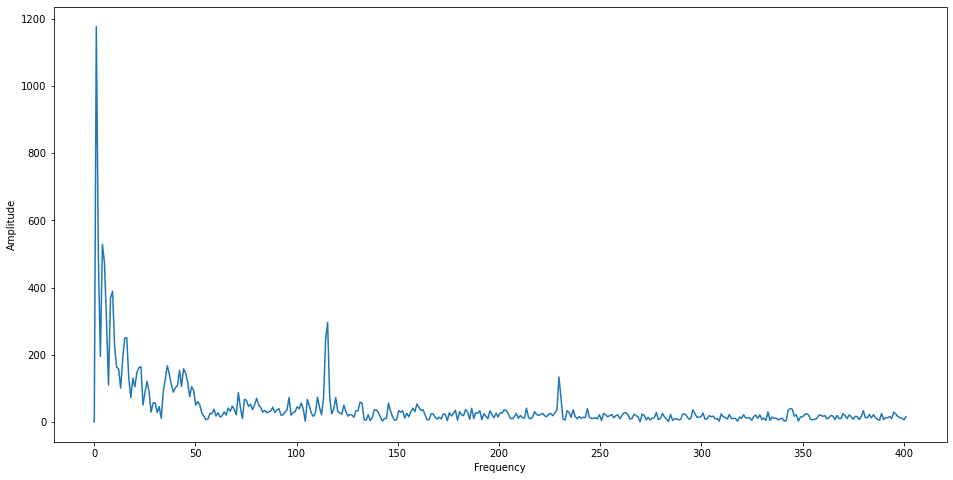

In [72]:
from scipy import fft

# Lets take a look at our data in frequency domain, we will use Fast Fourier transformation for that.
# I haven't used fft before, so these are the two links that i reffered in order to plot the fft
#https://dsp.stackexchange.com/questions/16181/matlab-remove-the-frequency-at-zero-in-fft?answertab=votes#tab-top
#https://alphabold.com/fourier-transform-in-python-vibration-analysis/

data=avg_views_per_language.transpose().en.values[1:] # This is the data that we are going to transform to analyse the frequency domain
data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
x=fft.fft(data) #Fourier Transformation
freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
y=2/550*np.abs(x[0:803//2]) # Taking absolute values of half data points 
plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freq,y)
plt.show()

One peak was observed at 120 days and other at 230 days, thus it can be said that it has quarterly seasonality as well.

#### For Espanish

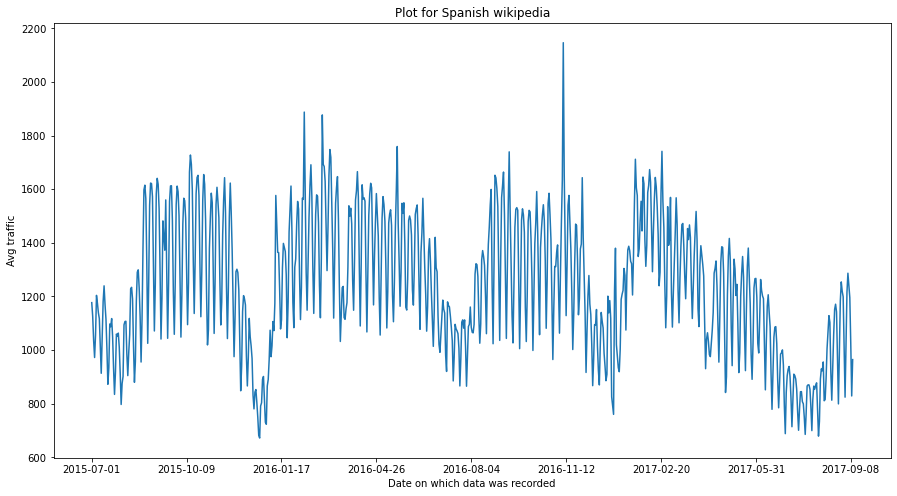

In [81]:
# Now, we will plot individual plot for every language to understand them in deep.
avg_views_per_language.loc['es'].transpose().plot(figsize=(15,8),title='Plot for Spanish wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

This graph shows that there is nice weekly seasonality present for spanish language. Spikes can be observed after every 7 days. 

Conclusion: Thus, we can interpret that it has weekly seasonality present in the graph.

#### Autocorrelation plot

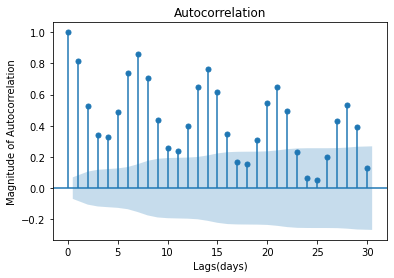

In [74]:
x=plot_acf(avg_views_per_language.transpose().es,lags=30)
plt.xlabel('Lags(days)')
plt.ylabel('Magnitude of Autocorrelation')
plt.show()

Just what we observed in the previous graph, the correlation is high for lag of 7 days.

Conclusion- Lag of 7 days in our AR model can produce good results for Spanish language.

#### Fourier Transform

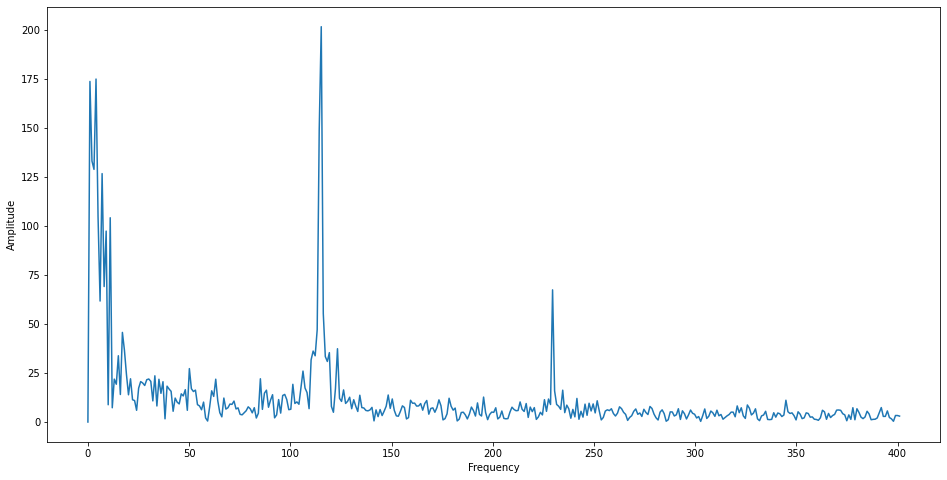

In [75]:
from scipy import fft

# Lets take a look at our data in frequency domain, we will use Fast Fourier transformation for that.
# I haven't used fft before, so these are the two links that i reffered in order to plot the fft
#https://dsp.stackexchange.com/questions/16181/matlab-remove-the-frequency-at-zero-in-fft?answertab=votes#tab-top
#https://alphabold.com/fourier-transform-in-python-vibration-analysis/

data=avg_views_per_language.transpose().es.values[1:] # This is the data that we are going to transform to analyse the frequency domain
data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
x=fft.fft(data) #Fourier Transformation
freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
y=2/550*np.abs(x[0:803//2]) # Taking absolute values of half data points 
plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freq,y)
plt.show()

High peaks at 120 and 230 days shows that there is quarterly seasonality present whereas small peaks shows that there is weekly seasonality present in the data.

#### For French

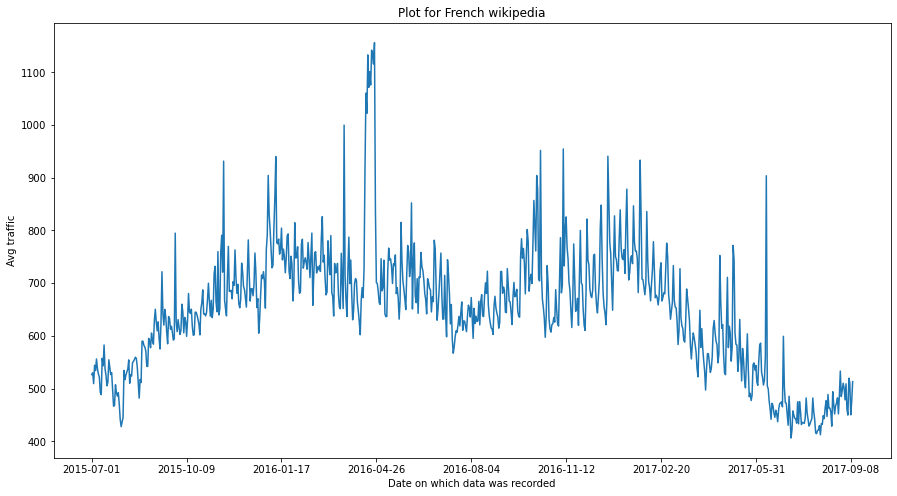

In [82]:
# Now, we will plot individual plot for every language to understand them in deep.
avg_views_per_language.loc['fr'].transpose().plot(figsize=(15,8),title='Plot for French wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

Just like russian here as well we can see an upward trend in the graph. Also the views increases in the month of nov/dec/jan part of the year.

#### Autocorrelation plot

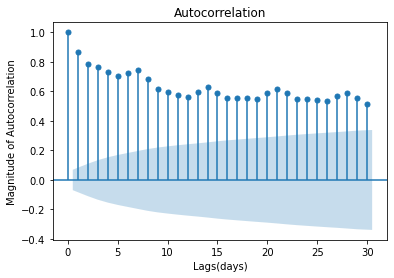

In [78]:
x=plot_acf(avg_views_per_language.transpose().fr,lags=30)
plt.xlabel('Lags(days)')
plt.ylabel('Magnitude of Autocorrelation')
plt.show()

Autocorrelation graph shows good correlation for 7 days, thus it also follows weekly seasonality.

Conclusion : Lag of 7 days could be useful.

#### Fourier Transform

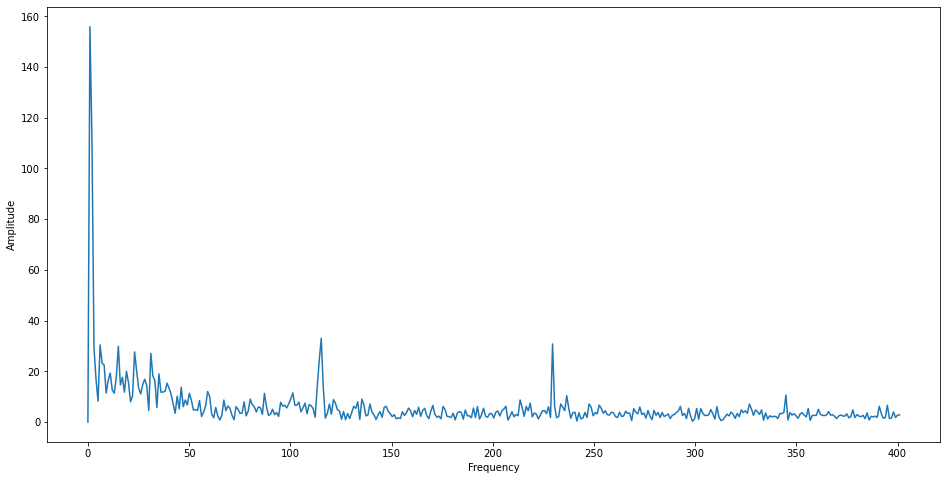

In [64]:
from scipy import fft

# Lets take a look at our data in frequency domain, we will use Fast Fourier transformation for that.
# I haven't used fft before, so these are the two links that i reffered in order to plot the fft
#https://dsp.stackexchange.com/questions/16181/matlab-remove-the-frequency-at-zero-in-fft?answertab=votes#tab-top
#https://alphabold.com/fourier-transform-in-python-vibration-analysis/

data=avg_views_per_language.transpose().fr.values[1:] # This is the data that we are going to transform to analyse the frequency domain
data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
x=fft.fft(data) #Fourier Transformation
freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
y=2/550*np.abs(x[0:803//2]) # Taking absolute values of half data points 
plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freq,y)
plt.show()

Sharp spikes at 120 and 230 days shows that there is quarterly and half-yearly seasonality present. Small spikes shows that there is some weekly seasonality as well.

#### For German

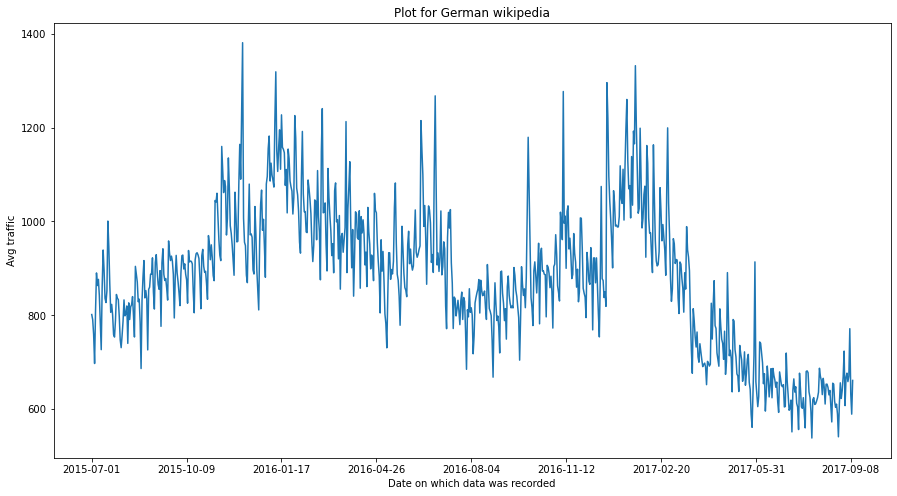

In [83]:
# Now, we will plot individual plot for every language to understand them in deep.
avg_views_per_language.loc['de'].transpose().plot(figsize=(15,8),title='Plot for German wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

Similar to french here as well we can see an upward trend in the graph. Also the views increases in the month of nov/dec/jan part of the year.

#### Autocorrelation plot

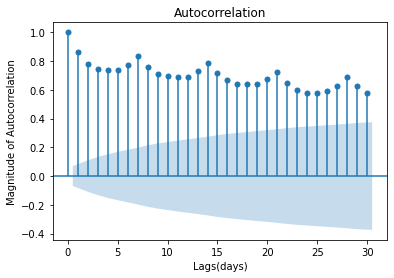

In [84]:
x=plot_acf(avg_views_per_language.transpose().de,lags=30)
plt.xlabel('Lags(days)')
plt.ylabel('Magnitude of Autocorrelation')
plt.show()

Autocorrelation graph shows good correlation for 7 days, thus it also follows weekly seasonality.

Conclusion : Lag of 7 days could be useful.

#### Fourier Transform

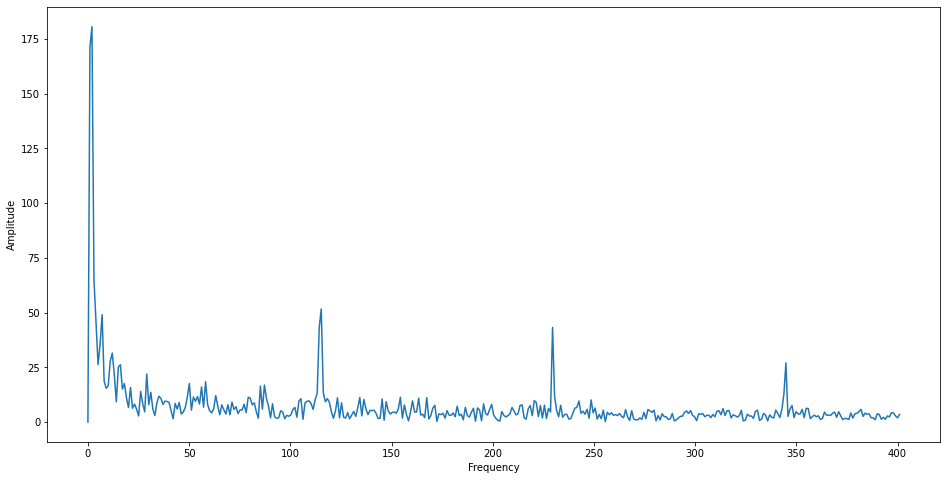

In [85]:
from scipy import fft

# Lets take a look at our data in frequency domain, we will use Fast Fourier transformation for that.
# I haven't used fft before, so these are the two links that i reffered in order to plot the fft
#https://dsp.stackexchange.com/questions/16181/matlab-remove-the-frequency-at-zero-in-fft?answertab=votes#tab-top
#https://alphabold.com/fourier-transform-in-python-vibration-analysis/

data=avg_views_per_language.transpose().de.values[1:] # This is the data that we are going to transform to analyse the frequency domain
data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
x=fft.fft(data) #Fourier Transformation
freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
y=2/550*np.abs(x[0:803//2]) # Taking absolute values of half data points 
plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freq,y)
plt.show()

Interestingly there is one more spike observed at 345 days along with the other ones at 120 and 230 days. 

Rest of the small peaks are same as that of previous languages. Hence, we conclude that here as well there is weekly and quarterly seasonality present.



#### For Japanese

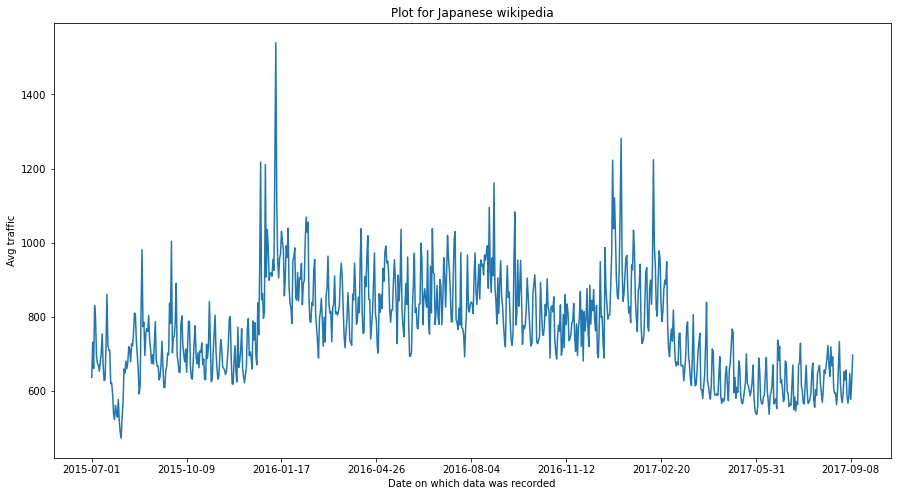

In [87]:
# Now, we will plot individual plot for every language to understand them in deep.
avg_views_per_language.loc['ja'].transpose().plot(figsize=(15,8),title='Plot for Japanese wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

A sharp spike was observed in Jan 2016, the traffic was increase in the same month and was more or less throughout next 1 year but then again it traffic decreased in Apr 2017

#### Autocorrelation plot

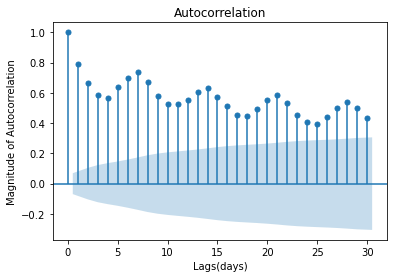

In [88]:
x=plot_acf(avg_views_per_language.transpose().ja,lags=30)
plt.xlabel('Lags(days)')
plt.ylabel('Magnitude of Autocorrelation')
plt.show()

Like rest of the language it shows good correlation for 7 days lag value.

Conclusion : Lag of 7 days could be a useful feature.

#### Fourier Transform

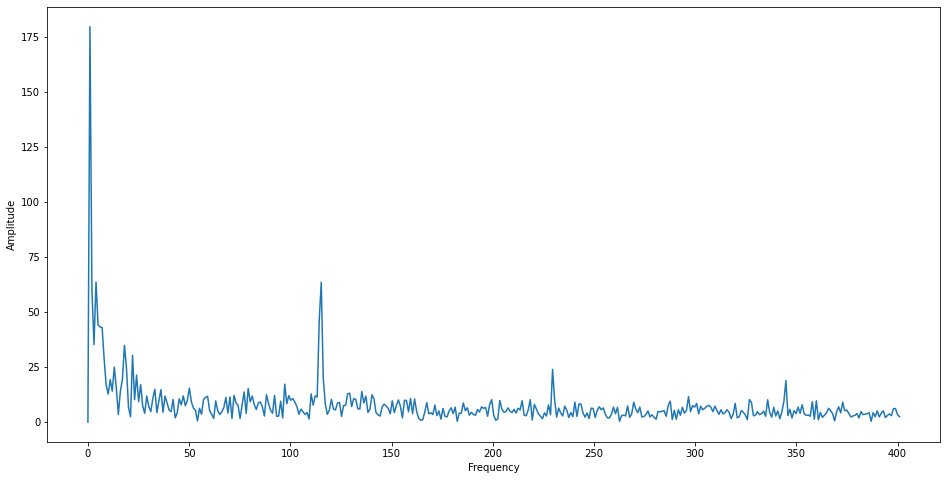

In [89]:
from scipy import fft

# Lets take a look at our data in frequency domain, we will use Fast Fourier transformation for that.
# I haven't used fft before, so these are the two links that i reffered in order to plot the fft
#https://dsp.stackexchange.com/questions/16181/matlab-remove-the-frequency-at-zero-in-fft?answertab=votes#tab-top
#https://alphabold.com/fourier-transform-in-python-vibration-analysis/

data=avg_views_per_language.transpose().ja.values[1:] # This is the data that we are going to transform to analyse the frequency domain
data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
x=fft.fft(data) #Fourier Transformation
freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
y=2/550*np.abs(x[0:803//2]) # Taking absolute values of half data points 
plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freq,y)
plt.show()

The spike at 120 days is very high here. Along with that just like german,here also we observed a spike at 345 days.

Conclusion : Weekly and quarterly seasonality present

#### For Chinese

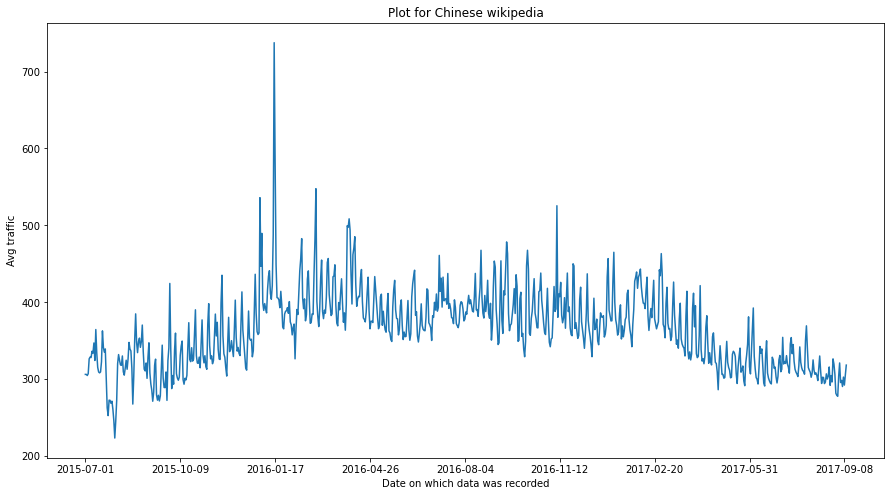

In [91]:
# Now, we will plot individual plot for every language to understand them in deep.
avg_views_per_language.loc['zh'].transpose().plot(figsize=(15,8),title='Plot for Chinese wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

This graph shows a very large spike in the month of January 2016, the traffic is showing upward trend initially and then throughout the year fluctuated in the same range.

#### Autocorrelation plot

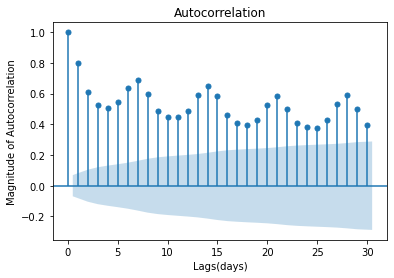

In [92]:
x=plot_acf(avg_views_per_language.transpose().zh,lags=30)
plt.xlabel('Lags(days)')
plt.ylabel('Magnitude of Autocorrelation')
plt.show()

Shows good correlation for 7 days lag value.

Conclusion : Lag of 7 days could be a useful feature.

#### Fourier Transform

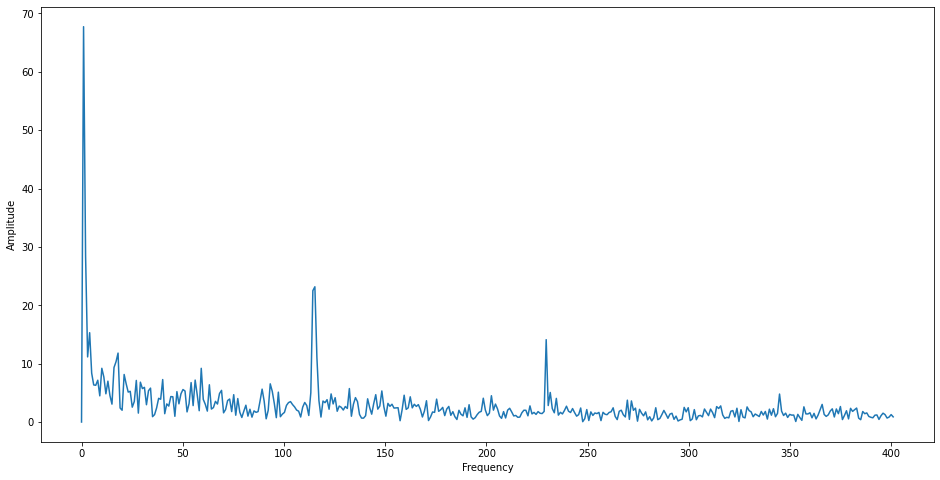

In [93]:
from scipy import fft

# Lets take a look at our data in frequency domain, we will use Fast Fourier transformation for that.
# I haven't used fft before, so these are the two links that i reffered in order to plot the fft
#https://dsp.stackexchange.com/questions/16181/matlab-remove-the-frequency-at-zero-in-fft?answertab=votes#tab-top
#https://alphabold.com/fourier-transform-in-python-vibration-analysis/

data=avg_views_per_language.transpose().zh.values[1:] # This is the data that we are going to transform to analyse the frequency domain
data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
x=fft.fft(data) #Fourier Transformation
freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
y=2/550*np.abs(x[0:803//2]) # Taking absolute values of half data points 
plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freq,y)
plt.show()

Similar as that of previous languages spikes can be seen at 120 and 230 days.

Conclusion : Weekly and quarterly seasonality present

#### For www

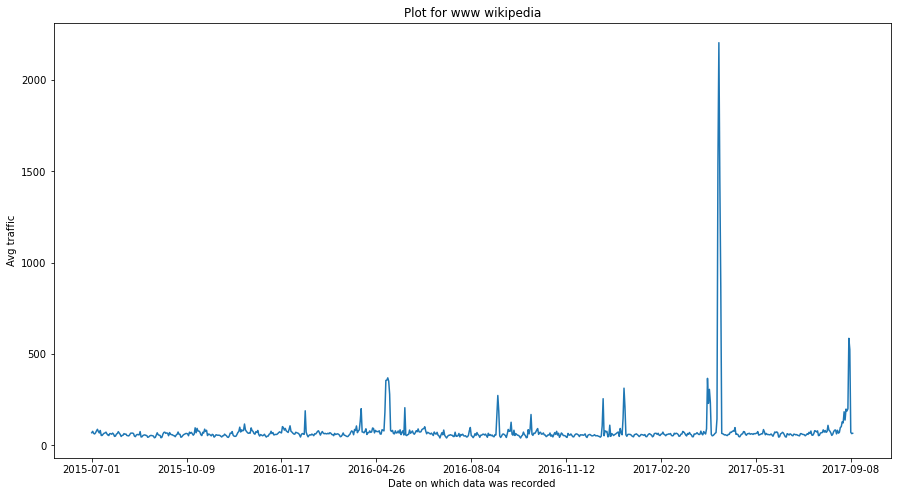

In [94]:
# Now, we will plot individual plot for every language to understand them in deep.
avg_views_per_language.loc['www'].transpose().plot(figsize=(15,8),title='Plot for www wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

For most of the duration the avg views it quite less but some high spikes can also be observed which shows that there must have been some event had occured around that time which resulted into increase in traffic.  

#### Autocorrelation plot

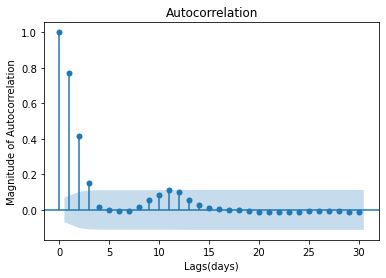

In [95]:
x=plot_acf(avg_views_per_language.transpose().www,lags=30)
plt.xlabel('Lags(days)')
plt.ylabel('Magnitude of Autocorrelation')
plt.show()

Only first few days have a high correlation value, but this may also be because of the fact that we don't have enough data to analyze.

#### Fourier Transform

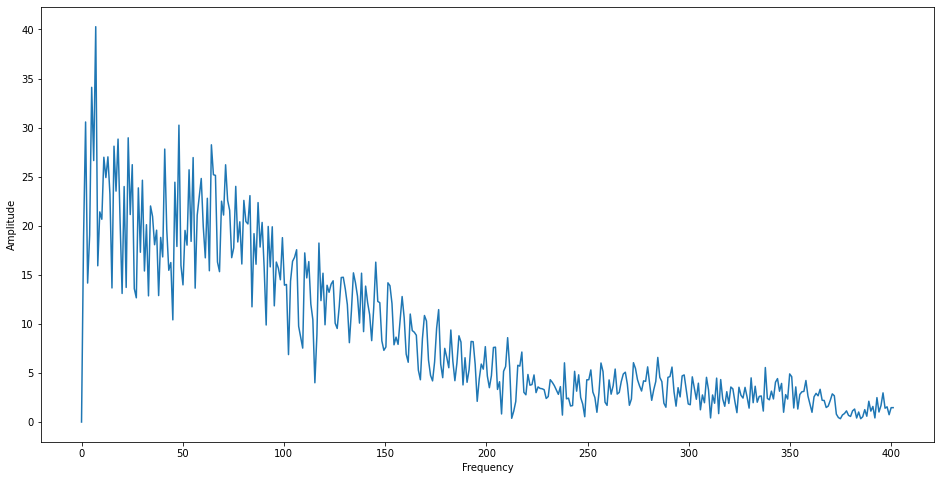

In [96]:
from scipy import fft

# Lets take a look at our data in frequency domain, we will use Fast Fourier transformation for that.
# I haven't used fft before, so these are the two links that i reffered in order to plot the fft
#https://dsp.stackexchange.com/questions/16181/matlab-remove-the-frequency-at-zero-in-fft?answertab=votes#tab-top
#https://alphabold.com/fourier-transform-in-python-vibration-analysis/

data=avg_views_per_language.transpose().www.values[1:] # This is the data that we are going to transform to analyse the frequency domain
data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
x=fft.fft(data) #Fourier Transformation
freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
y=2/550*np.abs(x[0:803//2]) # Taking absolute values of half data points 
plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freq,y)
plt.show()

Unlike other fft graphs this is quite different , the graph is continuosly decreasing and there is no sharp spikes that can be observed.

#### For commons

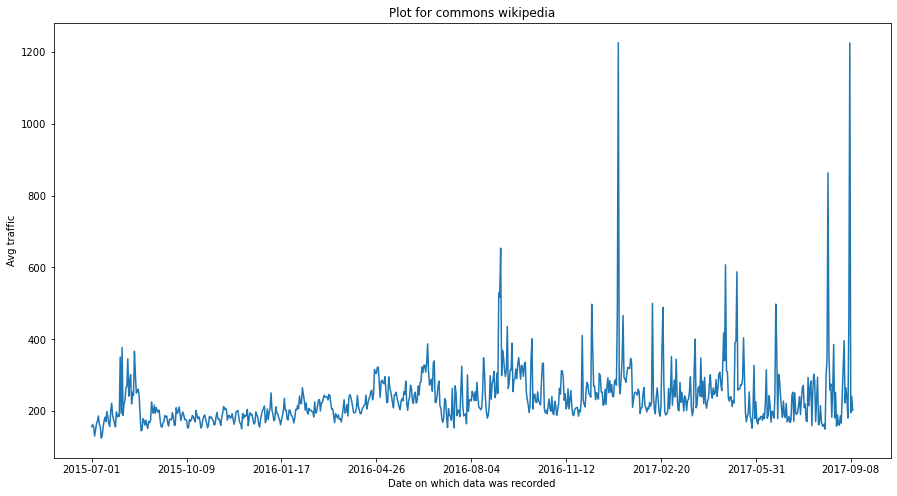

In [98]:
# Now, we will plot individual plot for every language to understand them in deep.
avg_views_per_language.loc['commons'].transpose().plot(figsize=(15,8),title='Plot for commons wikipedia')
plt.xlabel('Date on which data was recorded')
plt.ylabel('Avg traffic')
plt.show()

Avg views increases at a slow and steady pace and some sharp spikes can be seen in between. That may be because of occuring of some event.

#### Autocorrelation plot

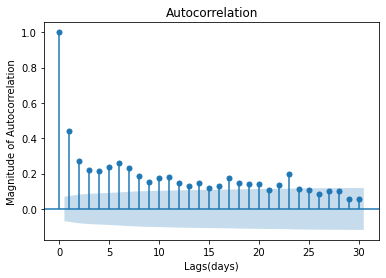

In [99]:
x=plot_acf(avg_views_per_language.transpose().commons,lags=30)
plt.xlabel('Lags(days)')
plt.ylabel('Magnitude of Autocorrelation')
plt.show()

Some correlation for 7 days lag value.

Conclusion : Lag of 7 days can still be used.

#### Fourier Transform

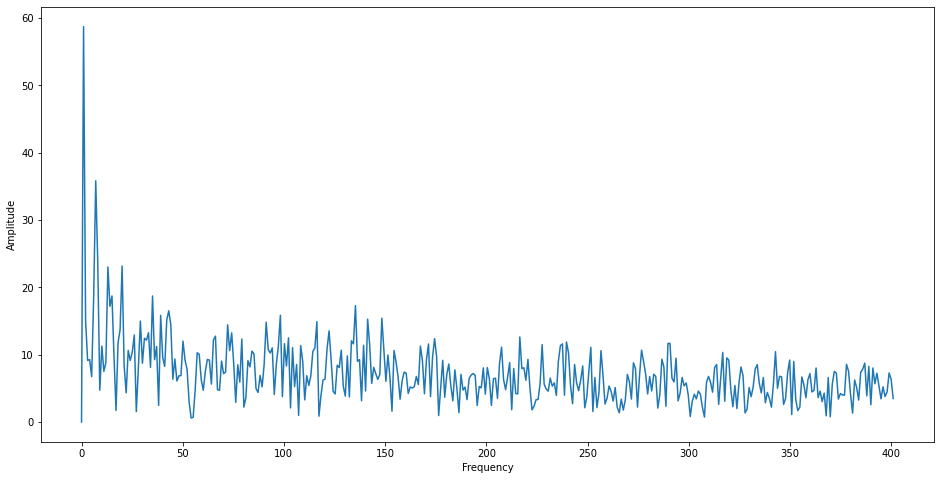

In [100]:
from scipy import fft

# Lets take a look at our data in frequency domain, we will use Fast Fourier transformation for that.
# I haven't used fft before, so these are the two links that i reffered in order to plot the fft
#https://dsp.stackexchange.com/questions/16181/matlab-remove-the-frequency-at-zero-in-fft?answertab=votes#tab-top
#https://alphabold.com/fourier-transform-in-python-vibration-analysis/

data=avg_views_per_language.transpose().commons.values[1:] # This is the data that we are going to transform to analyse the frequency domain
data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
x=fft.fft(data) #Fourier Transformation
freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
y=2/550*np.abs(x[0:803//2]) # Taking absolute values of half data points 
plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.plot(freq,y)
plt.show()

#### Quite similar as that of previous fft graph, it remains same throughout the duration and we can not find any sharp spikes as well.

Ok, so we were able to explore the data on the basis of each language and some key points that we observed were as follows:-

1) English Language has the most traffic compared to any other language.

2) Russian traffic's graph resembeles quite a lot with English Language.

3) Day of the month didn't show any patterns on the basis of which we can interpret anything but russian language slighlty had more traffic in first half of the month as compare to later half of the month but nothing conclusive can be said.

4) Graph on the basis of day of the week was quite insightful. Some key observations were:

    a) Russain , English, Espanish and German had more traffic in weekdays as compare to weekends.
    
    b) French has almost same traffic throughout the week except sunday.
    
    c) Japanese and Chinese had more traffic in the weekends as compare to weekdays.
    
    d) Interestingly www and commons had more traffic on tue,wed and thurs as compare to rest of the day.
    
5) It was observed for most of the languages traffic in first half of the year was more than the traffic in second half of the year.

4) We were able to see weekly seasonality in most of the languages and some even had quarterly/half-yearly seasonality.

5) Most of the lanuages showed an upward trend in first few months and downward trend in last few months.

6) Fourier Transformation had peaks at 120,230 and 345 days. So we will try to use these information for our features.

## 2.2 EDA Based on the Access of the page

In [101]:
from tqdm import tnrange as tnrange
from operator import add

access_views=[]
for i in range(len(access)):
  access_views.append(np.zeros(df.shape[1]-7))


for i in tnrange(len(df['Access'])):
    temp=access.index(df.iloc[i].Access)
    add_list=df.iloc[i].values[7:]
    access_views[temp]=list(map(add,access_views[temp],add_list))
    
access_views_df=pd.DataFrame(access_views,index=access,columns=df.columns.values[7:])
access_views_df.head(10)

<ipython-input-101-81130551df58>:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(df['Access'])):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [102]:
access_views_df=pd.DataFrame(access_views,index=access,columns=df.columns.values[7:])
access_views_df.head(10)

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
all-access,74698113.0,75607094.0,71086918.0,73484575.0,76515131.0,80887270.0,77524236.0,75035659.0,75411555.0,74763214.0,...,75795161.0,74613022.0,86035656.0,86035031.0,83479213.0,90949563.0,96568777.0,69516542.0,67239881.0,68036785.0
desktop,39876738.0,40166627.0,35875973.0,33600249.0,35422879.0,43426624.0,41902900.0,39665135.0,40134196.0,39372719.0,...,39560352.0,36200038.0,41613306.0,45823050.0,45773630.0,49597055.0,52789777.0,36060473.0,30735840.0,35387918.0
mobile-web,34097625.0,33820119.0,34201307.0,38528113.0,39557362.0,36428340.0,34720237.0,34160117.0,33986384.0,34238554.0,...,31327545.0,34067985.0,38413438.0,34933425.0,32937745.0,31807528.0,31372730.0,31177655.0,34383791.0,38439246.0


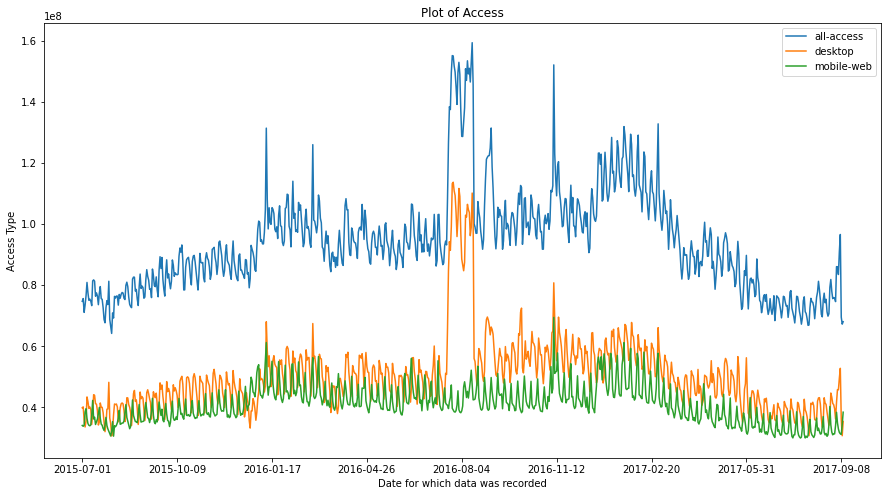

In [105]:
# Plotting the traffic of each language on a single plot to understand their scale
access_views_df.transpose().plot(figsize=(15,8),title='Plot of Access')
plt.xlabel('Date for which data was recorded')
plt.ylabel('Access Type')
plt.show()

### 2.2.1 Bar Plot

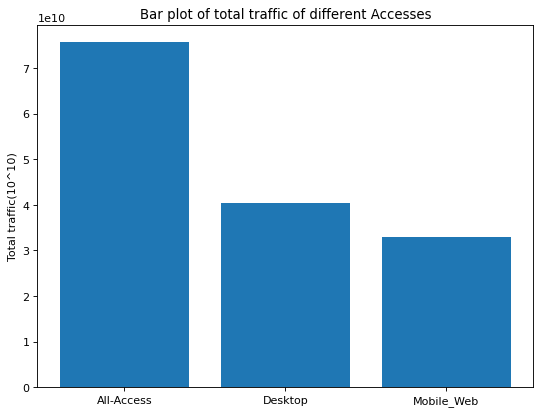

In [106]:
# Lets take a look on the total traffic bys apider and non-spider during 803 days
all_access = np.sum(access_views_df.iloc[0].transpose())
desktop = np.sum(access_views_df.iloc[1].transpose())
mobile_web = np.sum(access_views_df.iloc[2].transpose())
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(['All-Access','Desktop','Mobile_Web'],[all_access,desktop,mobile_web])
plt.title('Bar plot of total traffic of different Accesses')
plt.ylabel('Total traffic(10^10)')
plt.show()

We can clearly observe that All-Access contribute most to the traffic,then Desktop and Mobile_Web contributes the least. 

One more thing to observe is that All-Access and Desktop both have graphs that is very similar to that of English and Russian Language which is quite obvious because both pages contributes most to our dataset but what is surprising is that Mobile web is having a flat graph. 

## 2.3 EDA Based on the Agent of the page

In [107]:
from tqdm import tnrange as tnrange
from operator import add

agent_views=[]
for i in range(len(agent)):
  agent_views.append(np.zeros(df.shape[1]-7))


for i in tnrange(len(df['Agent'])):
    temp=agent.index(df.iloc[i].Agent)
    add_list=df.iloc[i].values[7:]
    agent_views[temp]=list(map(add,agent_views[temp],add_list))

<ipython-input-107-a7159527415e>:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(df['Agent'])):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [108]:
agent_views_df=pd.DataFrame(agent_views,index=agent,columns=df.columns.values[7:])
agent_views_df.head(10)

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
spider,664648.0,619550.0,595102.0,613861.0,622344.0,583581.0,624445.0,766410.0,808719.0,748612.0,...,5503108.0,4763155.0,6859769.0,5903942.0,4911143.0,9837486.0,14079652.0,2120820.0,1984403.0,1993236.0
all-agents,148007828.0,148974290.0,140569096.0,144999076.0,150873028.0,160158653.0,153522928.0,148094501.0,148723416.0,147625875.0,...,141179950.0,140117890.0,159202631.0,160887564.0,157279445.0,162516660.0,166651632.0,134633850.0,130375109.0,139870713.0


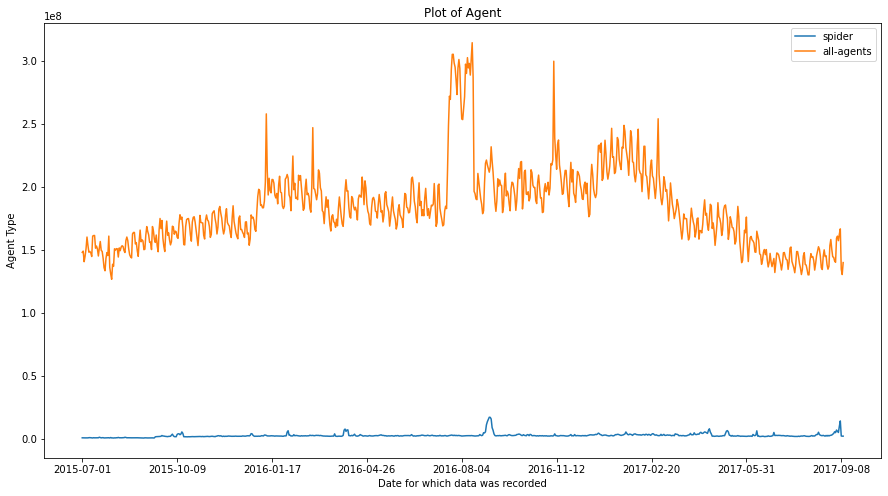

In [113]:
# Plotting the traffic of each language on a single plot to understand their scale
agent_views_df.transpose().plot(figsize=(15,8),title='Plot of Agent')
plt.xlabel('Date for which data was recorded')
plt.ylabel('Agent Type')
plt.show()

### 2.3.1 Bar Plot

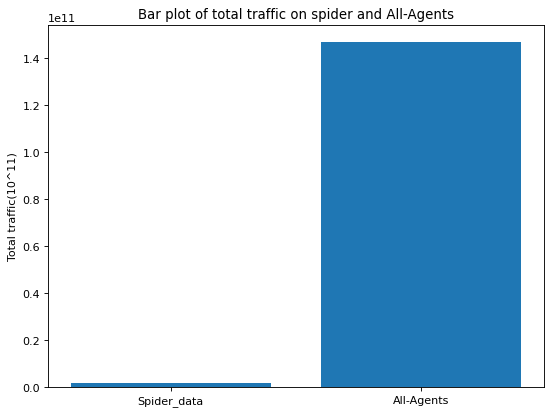

In [110]:
# Lets take a look on the total traffic bys apider and non-spider during 803 days
a=np.sum(agent_views_df.transpose().spider)
b=np.sum(agent_views_df[1:].transpose())
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(['Spider_data','All-Agents'],[a,b])
plt.title('Bar plot of total traffic on spider and All-Agents')
plt.ylabel('Total traffic(10^11)')
plt.show()

We can observe that there is flat line for spider's data because there is a large difference in the scale of Spider vs All Agents data. 

Let's take a look at them individually.

### 2.3.2 Individually observing data for Spider and Non Spider data

#### Spider

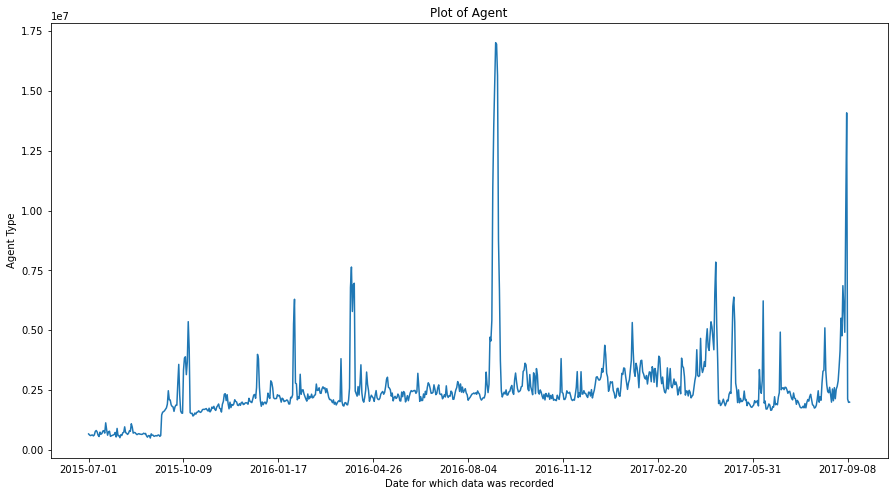

In [114]:
# Plotting the traffic of each language on a single plot to understand their scale
agent_views_df.iloc[0].transpose().plot(figsize=(15,8),title='Plot of Agent')
plt.xlabel('Date for which data was recorded')
plt.ylabel('Agent Type')
plt.show()

In the first few months the traffic didn't show any upward movement , after that an upward trend was observed for next few months and then throughout the duration it didn't showed any upward trends however some sharp spikes can be observed for some period especially in Aug 16. Regular spikes were also observed throughout the duration.

#### All Agents

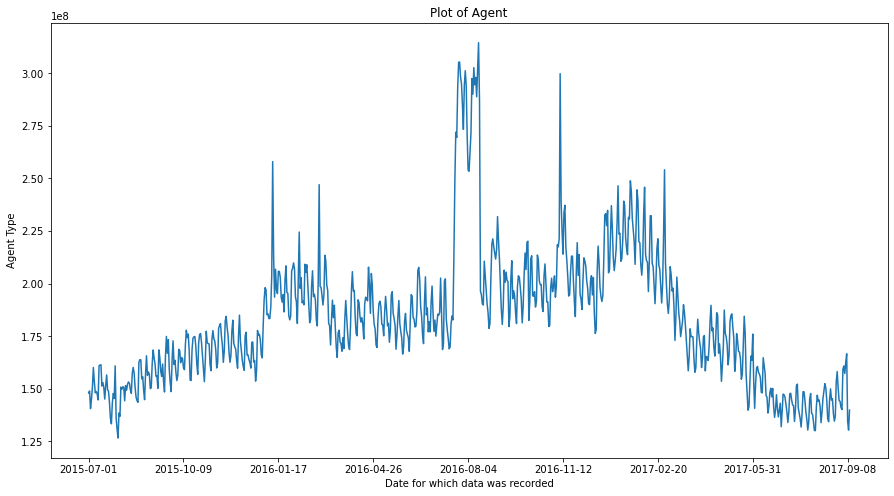

In [115]:
# Plotting the traffic of each language on a single plot to understand their scale
agent_views_df.iloc[1].transpose().plot(figsize=(15,8),title='Plot of Agent')
plt.xlabel('Date for which data was recorded')
plt.ylabel('Agent Type')
plt.show()

Interestingly this graph is almost similar like English or Russian Language. This could be because of the fact that most of the data's agent is not spider and English and Russian are the pages contributing most to the traffic(specially English pages). 
The same spike that we have here at August 16 was observed in English and Russian Pages as well. This may be because of some event occuring during that period. Olympics 16 can be one of the reason for these spikes.